# What Zipcodes in the United States Offer the Most Attractive Returns?

## Organizational Overview

R.E.A.L real estate company is looking to purchase properties in the United States to return profit. The company wants to know which five zipcodes offer the most attractive returns on their investment within periods of two, three, and four years. This research aims to use several time series models to determine these zipcodes.

#### Research Questions

Which zipcodes offer the best returns on years 1, 2, and 3 after initial investment?

Which zipcodes are most predictable in price fluctuation?

#### Dataset

The dataset used for this research is from Zillow Research. The features it includes are:
- RegionID, RegionName, City, State, Metro, CountyName, SizeRank as well as dates corresponding to the values of each feature in wide format

#### Methods

- Random Walk
- Autoregression (AR)
- Moving Average (MA)
- Autogression Integrated Moving Average (ARIMA)
- Seasonal Autogression Integrated Moving Average (SARIMA)

In [1]:
import pandas as pd

import numpy as np

import seaborn as sns

from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error


import warnings
warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:,.2f}'.format
# pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
# !pip install pmdarima

In [3]:
ls

CONTRIBUTING.md           Phase4ProjectDraft.ipynb  images/
LICENSE.md                README.md                 time-series/


In [4]:
cd time-series/

/Users/eldrichvergarciadoyogan/Documents/Flatiron/Projects/Phase4Project/dsc-phase-4-project/time-series


In [5]:
ls

README.md               starter_notebook.ipynb  zillow_data.csv


In [6]:
data = pd.read_csv('zillow_data.csv')

## Initial Data Exploration

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [8]:
data.dtypes.head()

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
dtype: object

In [9]:
data.head()
# The data is in wide format

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [10]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [11]:
# dates = data.columns[8:]

In [12]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [13]:
melt_data(data)

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312
...,...
2017-12-01,281095.320247
2018-01-01,282657.060382
2018-02-01,284368.688447


In [14]:
data.columns

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', '1996-04', '1996-05', '1996-06',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=272)

In [15]:
data_melt = pd.melt(data, id_vars = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name = 'Time', value_name = 'Value')

In [16]:
data_melt.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Time,Value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0


In [17]:
data_melt.dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
Time           object
Value         float64
dtype: object

In [18]:
data_melt['Time'] = pd.to_datetime(data_melt['Time'], format='%Y-%m')

In [19]:
data_melt.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Time,Value
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0


In [20]:
data_melt.dtypes

RegionID               int64
RegionName             int64
City                  object
State                 object
Metro                 object
CountyName            object
SizeRank               int64
Time          datetime64[ns]
Value                float64
dtype: object

In [21]:
def check_na(df, columns_list):
    """Takes in a column from a pandas dataframe and checks if the column
    contains null values
    
    Parameters:
    df: pandas DataFrame
    columns_list: list of columns in DataFrame 
    """
    for column in columns_list:
        if len(df.loc[df[column].isna() == True]) >= 1:
            print(column, "True")
        else:
            print(column, "False")

In [22]:
check_na(data_melt, data_melt.columns)

RegionID False
RegionName False
City False
State False
Metro True
CountyName False
SizeRank False
Time False
Value True


In [23]:
data_melt['Metro'].unique()

array(['Chicago', 'Dallas-Fort Worth', 'Houston', 'El Paso', 'New York',
       'San Francisco', 'The Villages', 'Nashville',
       'Los Angeles-Long Beach-Anaheim', 'Austin', 'Charlotte', 'McAllen',
       'Atlanta', 'Washington', 'San Antonio', 'Clarksville', 'St. Louis',
       'Oklahoma City', 'Phoenix', 'Baltimore', 'Miami-Fort Lauderdale',
       'Brownsville', 'Virginia Beach', 'Seattle', 'Cleveland',
       'Ann Arbor', 'Boston', 'Kansas City', 'Sacramento', 'Tucson',
       'Jacksonville', 'Napa', 'San Diego', 'Albuquerque', 'Hartford',
       'Las Vegas', 'Lancaster', 'Fresno', 'Denver', 'Detroit', 'Vallejo',
       'Pittsburgh', 'Columbus', 'Portland', 'Riverside', 'Yuma',
       'Ithaca', 'Springfield', 'Fort Myers', nan, 'Cincinnati', 'Tampa',
       'Columbia', 'Lafayette-West Lafayette', 'Fayetteville', 'Raleigh',
       'Kennewick', 'College Station', 'Hagerstown', 'Philadelphia',
       'Richmond', 'Indianapolis', 'Tulsa', 'Orlando', 'Greenville',
       'Ventura', 'S

In [24]:
data_melt.loc[data_melt['Value'].isna() == True]['City'].value_counts().head()

Huntsville       1839
New York         1152
Columbus         1118
Jackson           750
Oklahoma City     699
Name: City, dtype: int64

In [25]:
data_melt['City'].value_counts().mean()

516.4939105109876

In [26]:
data_melt.set_index('Time', inplace = True)

In [27]:
data_melt.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


In [28]:
#Dropping the rows where 'Value' is null
#Replace null values in column 'Metro' with value 'None'

data_melt['Metro'].fillna('None', inplace = True)

In [29]:
data_melt['Metro'].head()

Time
1996-04-01              Chicago
1996-04-01    Dallas-Fort Worth
1996-04-01              Houston
1996-04-01              Chicago
1996-04-01              El Paso
Name: Metro, dtype: object

In [30]:
data_melt = data_melt[data_melt['Value'].notna()]

In [31]:
data_melt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3744704 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionID    int64  
 1   RegionName  int64  
 2   City        object 
 3   State       object 
 4   Metro       object 
 5   CountyName  object 
 6   SizeRank    int64  
 7   Value       float64
dtypes: float64(1), int64(3), object(4)
memory usage: 257.1+ MB


<AxesSubplot:xlabel='time'>

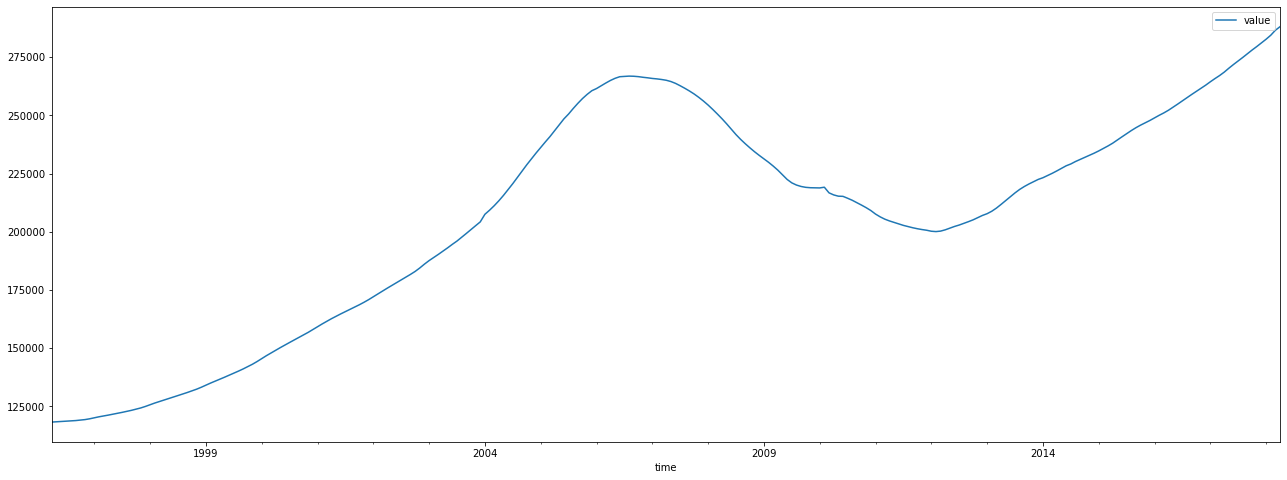

In [32]:
melt_data(data).plot(figsize = (22,8))

In [33]:
melt_data(data).max()

value    288039.944305
dtype: float64

The general trend of mean prices based on zipcode follows a positive slope. There is a local minumum around 2012. The decline in property values began sometime in 2007. The 2007/08 global financial collapse due to the housing market bubble burst is most likely to blame. Between 2007 and 2013, the property value mean decreased some 30%: from a local maximum of \\$288,039 to a trough hovering just above \\$200,000. Furthermore, the mean does not stay relatively constant over time, thus making the data set non-stationary. 

In [34]:
time_series = melt_data(data)

In [35]:
# time_series.hist(figsize = (12,6), bins = 100)
# plt.show()

In [36]:
data_melt.dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
Value         float64
dtype: object

In [37]:
data_melt['Value'] = data_melt['Value'].astype(int)

In [38]:
data_melt.dtypes

RegionID       int64
RegionName     int64
City          object
State         object
Metro         object
CountyName    object
SizeRank       int64
Value          int64
dtype: object

In [39]:
def boxit(DataFrame, independent, dependent):
    """ Returns boxplot of chosen independent column and dependent column.
        
        Parameters:
        DataFrame: A Pandas DataFrame
        Independent: Column or feature from dataframe to be chosen as the predictor variable
        Dependent: Column to be predicted
        """
    ax = sns.boxplot(data = DataFrame, x = independent, y = dependent)
    return

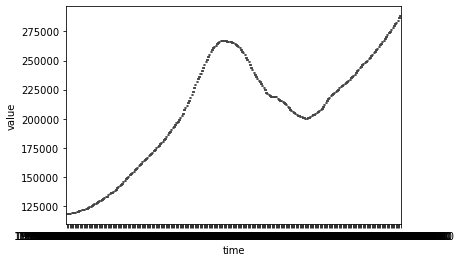

In [40]:
boxit(time_series, time_series.index, 'value')

In [41]:
time_series.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


### Omitting Years and Shifting Focus to Cities

As seen in the line plot above, the housing market crash of 2007/2008 had a profound effect on housing prices; with prices bottoming out between 2011 and 2012. Omitting the years before the trough of the data will allow later models to provide better forecasting. Furthermore, the Organisation for Economic Co-operation and Development asserts that cities experience larger real-estate growth compared to non-urban regions. Furthermore, due to faster population growth in more urbanized regions, the firm will have more oppurtunities to sell to possible buyers looking to move to cities. In favor of predictability and seeking high returns on investments, this analysis will forego the data prior to 2012, and focus on zipcodes within the top 20% of the 'SizeRank' column. 

In [42]:
data_melt.loc[data_melt['City'] == 'New York'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
1996-04-01,61807,10467,New York,NY,New York,Bronx,7,152900
1996-04-01,62037,11226,New York,NY,New York,Kings,11,162000
1996-04-01,62087,11375,New York,NY,New York,Queens,13,252400
1996-04-01,62045,11235,New York,NY,New York,Kings,14,190500
1996-04-01,61703,10128,New York,NY,New York,New York,22,3676700


In [43]:
data_melt = data_melt.loc[data_melt.index >= '2012-01-01']

In [44]:
data_melt.head(5)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,737700
2012-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,199600
2012-01-01,91982,77494,Katy,TX,Houston,Harris,3,248600
2012-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,928900
2012-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,112400


In [45]:
print(data_melt['SizeRank'].max()/5)

2944.6


In [46]:
data_melt = data_melt.loc[data_melt['SizeRank'] <= 2945]

In [47]:
data_melt.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,84654,60657,Chicago,IL,Chicago,Cook,1,737700
2012-01-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,199600
2012-01-01,91982,77494,Katy,TX,Houston,Harris,3,248600
2012-01-01,84616,60614,Chicago,IL,Chicago,Cook,4,928900
2012-01-01,93144,79936,El Paso,TX,El Paso,El Paso,5,112400


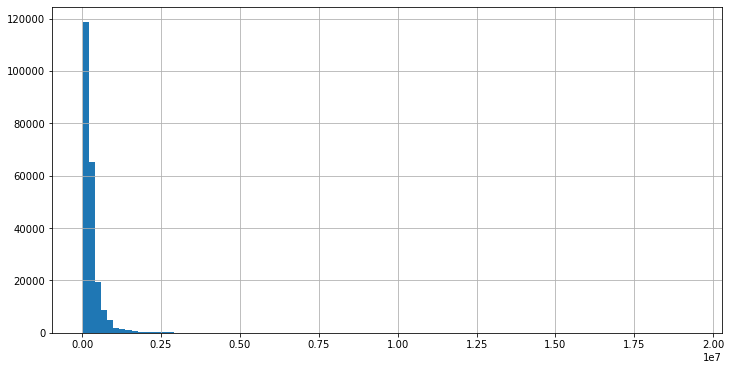

In [48]:
data_melt['Value'].hist(figsize = (12,6), bins = 100 )
plt.show()

### Narrowing Down Further

#### Means of Median-Price per City

In [49]:
cities = data_melt['City'].unique()

In [50]:
cities

array(['Chicago', 'McKinney', 'Katy', ..., 'Peachtree City',
       'Candler-Mcafee', 'Dalton'], dtype=object)

In [51]:
def city_mean_value(df, column_name, list_object):
    """Takes dataframe and list of city names and returns 
    values of mean prices according to city
    
    Parameters:
    df: pandas DataFrame
    column_name: Chosen column to parse
    list_object: list of values present in the column"""
    
    cities = {}
    for objects in list_object:
        cities[objects] = df.loc[df[column_name] == objects]['Value'].mean()
    return cities

In [52]:
# Creating a dictionary to house city_mean_value output
city_means = city_mean_value(data_melt, 'City', cities)

In [53]:
# Turning the dictionary into a pandas DataFrame
city_means = pd.DataFrame(city_means, index = [0])

In [54]:
# The original dataframe is in wide format, melting it to long format
city_means = pd.melt(city_means)

In [55]:
city_means.head()

,variable,value
0,Chicago,426214.383043
1,McKinney,235519.736842
2,Katy,220038.815789
3,El Paso,116054.887218
4,Houston,257193.940443


In [56]:
city_means.sort_values(["value"], ascending = False).head(10)
# The top 5 cities in terms of mean-median housing are West Hollywood, Burlingame, Manhattan Beach,
# Palo Alto, and San Francisco

,variable,value
1037,West Hollywood,2.467001e+06
722,Burlingame,2.202325e+06
1104,Manhattan Beach,1.981975e+06
1128,Palo Alto,1.962830e+06
6,San Francisco,1.894669e+06
928,Menlo Park,1.870001e+06
1050,Santa Monica,1.851334e+06
292,Cupertino,1.739883e+06
923,Newport Beach,1.674211e+06
995,Mountain View,1.582924e+06


In [57]:
data_melt.loc[data_melt['City'] == 'West Hollywood'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,96050,90069,West Hollywood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1897,1630400
2012-02-01,96050,90069,West Hollywood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1897,1637700
2012-03-01,96050,90069,West Hollywood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1897,1655600
2012-04-01,96050,90069,West Hollywood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1897,1687000
2012-05-01,96050,90069,West Hollywood,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1897,1719600


In [58]:
data_melt.loc[data_melt['City'] == 'Burlingame'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,97501,94010,Burlingame,CA,San Francisco,San Mateo,1266,1445000
2012-02-01,97501,94010,Burlingame,CA,San Francisco,San Mateo,1266,1447600
2012-03-01,97501,94010,Burlingame,CA,San Francisco,San Mateo,1266,1457400
2012-04-01,97501,94010,Burlingame,CA,San Francisco,San Mateo,1266,1475100
2012-05-01,97501,94010,Burlingame,CA,San Francisco,San Mateo,1266,1507400


In [59]:
data_melt.loc[data_melt['City'] == 'Manhattan Beach'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,96117,90266,Manhattan Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2011,1322400
2012-02-01,96117,90266,Manhattan Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2011,1331700
2012-03-01,96117,90266,Manhattan Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2011,1342800
2012-04-01,96117,90266,Manhattan Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2011,1361200
2012-05-01,96117,90266,Manhattan Beach,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2011,1385100


In [60]:
data_melt.loc[data_melt['City'] == 'Palo Alto'].head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,97693,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1136700
2012-02-01,97693,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1155000
2012-03-01,97693,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1182500
2012-04-01,97693,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1203500
2012-05-01,97693,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1219600


In [61]:
data_melt.loc[data_melt['City'] == 'San Francisco'].head()
#Compared to other cities, San Francisco contains multiple zipcodes under the 'City' column

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,2244700
2012-01-01,97565,94110,San Francisco,CA,San Francisco,San Francisco,77,755700
2012-01-01,97576,94122,San Francisco,CA,San Francisco,San Francisco,334,685300
2012-01-01,97567,94112,San Francisco,CA,San Francisco,San Francisco,505,512300
2012-01-01,97569,94115,San Francisco,CA,San Francisco,San Francisco,743,2323000


In [62]:
len(data_melt.loc[data_melt['City'] == 'San Francisco'])
# Checking the length of the dataset only containing the city of San Francisco

1140

In [63]:
data_melt.loc[data_melt['City'] == 'San Francisco']['RegionName'].unique()
# Looking at how many different zipcodes there are in the city

array([94109, 94110, 94122, 94112, 94115, 94117, 94121, 94118, 94114,
       94103, 94107, 94116, 94123, 94131, 94133])

In [64]:
#Creating a dataset that includes only the top five cities
topCities = data_melt.loc[data_melt['City'].isin(['West Hollywood', 'Burlingame', 
                                      'Manhattan Beach', 'Palo Alto', 'San Francisco'])]

In [65]:
len(topCities)

1444

In [66]:
def plot_value(df, column_name, list_object):
    """Takes dataframe and list of city names and returns 
    values of prices according to city
    
    Parameters:
    df: pandas DataFrame
    column_name: Chosen column to parse
    list_object: list of values present in the column"""
    
    cities = pd.DataFrame()
    for objects in list_object:
        cities[objects] = df.loc[df[column_name] == objects]['Value']
    return cities

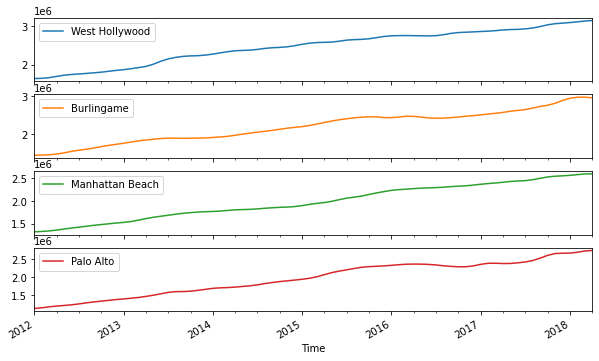

In [67]:
plot_value(topCities, 'City', ['West Hollywood','Burlingame','Manhattan Beach','Palo Alto']).plot(
    figsize = (10,6), subplots=True, legend=True)
plt.show()
# Similar to the initial graph that includes data from all the zipcodes, the top five cities exhibit an
# upward linear trend. 

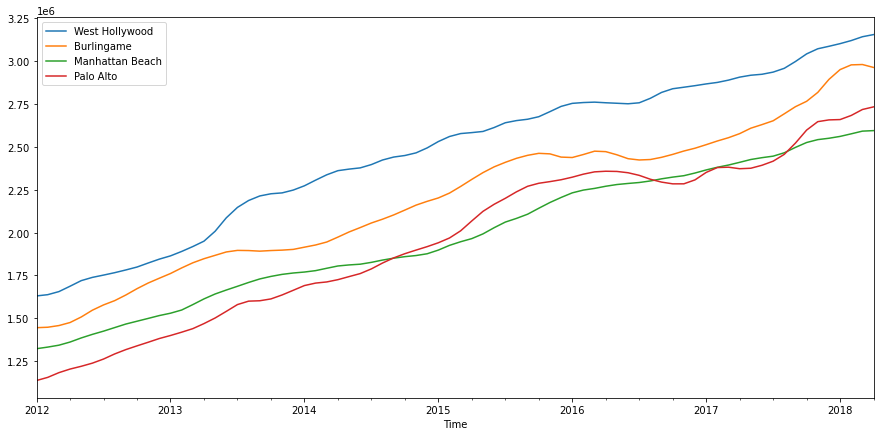

In [68]:
plot_value(topCities, 'City', ['West Hollywood','Burlingame','Manhattan Beach','Palo Alto']).plot(
    figsize = (15,7), subplots=False, legend=True)
plt.show()
# Top four cities' graphs superimposed on one graph

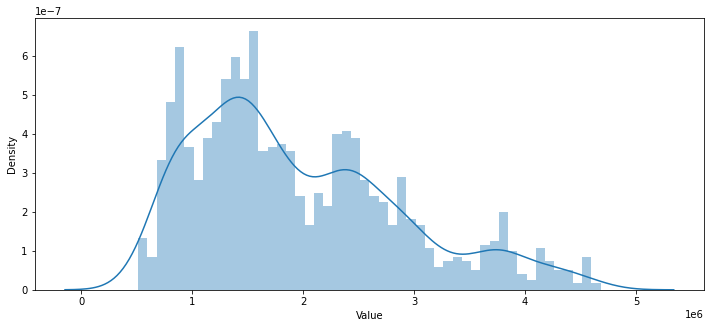

In [69]:
fig, ax = plt.subplots(figsize = (12,5))
ax = sns.distplot(a=topCities['Value'], bins = 50)
 
plt.show()
# Showing the distribution of prices gathered from West Hollywood, Burlingame, Manhattan Beach, and Palo Alto

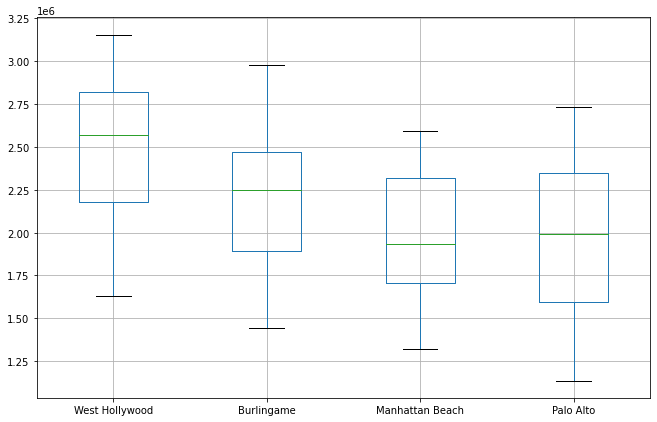

In [70]:
plot_value(topCities, 'City', ['West Hollywood','Burlingame','Manhattan Beach','Palo Alto']).boxplot(
    figsize = (11,7),)
plt.show()
# The boxplots show the distrubtion of prices amongst each city, with the length of the whiskers 
# showing outliers

In [71]:
sanFran = topCities.loc[topCities['City'] == 'San Francisco']
# Because there are 15 different in San Francisco, I created separate visualizations

In [72]:
sanFran.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,2244700
2012-01-01,97565,94110,San Francisco,CA,San Francisco,San Francisco,77,755700
2012-01-01,97576,94122,San Francisco,CA,San Francisco,San Francisco,334,685300
2012-01-01,97567,94112,San Francisco,CA,San Francisco,San Francisco,505,512300
2012-01-01,97569,94115,San Francisco,CA,San Francisco,San Francisco,743,2323000


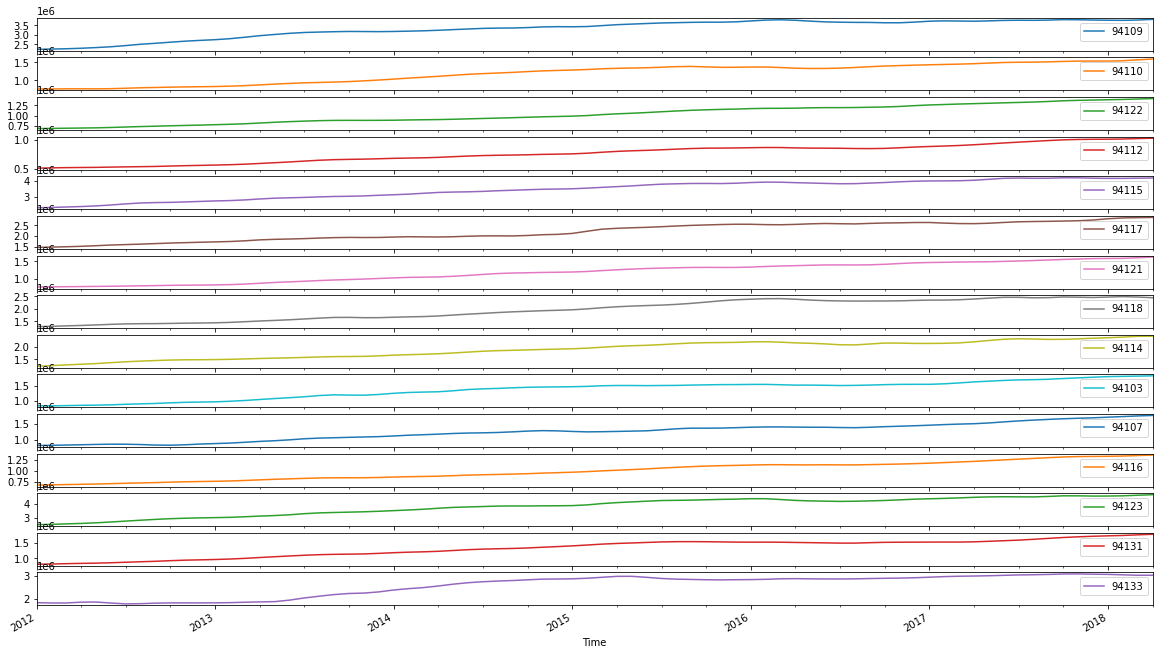

In [73]:
plot_value(sanFran, 'RegionName', sanFran['RegionName'].unique()).plot(
    figsize = (20,12), subplots=True, legend=True)
fig.tight_layout()
plt.show()

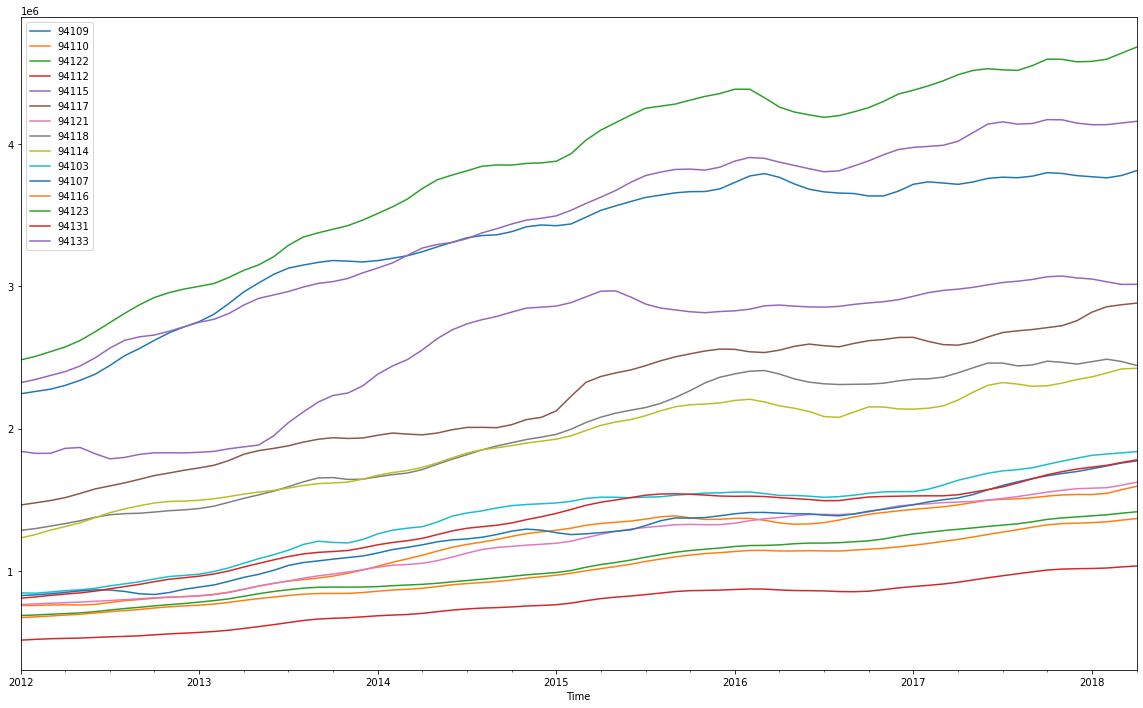

In [74]:
plot_value(sanFran, 'RegionName', sanFran['RegionName'].unique()).plot(
    figsize = (20,12), subplots=False, legend=True)
fig.tight_layout()
plt.show()
# Zipcode 94123 has the highest mean median-housing per zipcode in San Francisco

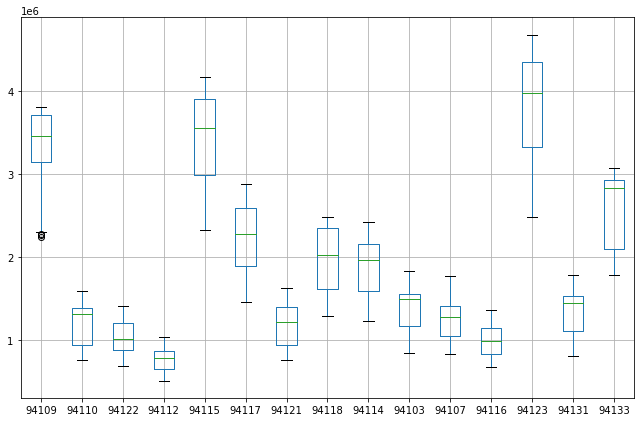

In [75]:
plot_value(topCities, 'RegionName', sanFran['RegionName'].unique()).boxplot(
    figsize = (11,7),)
plt.show()

Although the cities of West Hollywood, Burlingame, Manhattan Beach, Palo Alto, and San Francisco boasted the highest mean median housing prices, it does not necessarily provide insight into the relationship between time and real estate value. Considering different metrics to gauge the profitability of regions should provide better insight.

#### Difference Between First and Last Month Prices

In [76]:
# The function substracts the median price from the first entry (12-01-01) from the median price of the last entry
# (2018-04-01) and returns a dictionary of the difference
def city_val_dif(df, column_name, list_object):
    """Takes dataframe and list of city names and returns 
    values of first month prices subtracted from first month
    prices according to city
    
    Parameters:
    df: pandas DataFrame
    column_name: Chosen column to parse
    list_object: list of values present in the column"""
    
    cities = {}
    for objects in list_object:
        cities[objects] = [df.loc[df[column_name] == objects]
                               ['Value'][-1] - df.loc[df[column_name] == objects]['Value'][0]]
    return cities

In [77]:
# Creating a dictionary
lastFirst = city_val_dif(data_melt, 'City', cities)

In [78]:
# Turning dictionary into a pandas DataFrame
lastFirst = pd.DataFrame(lastFirst, index = [0])

In [79]:
# Pivoting dataframe from wide to long format
lastFirst = pd.melt(lastFirst)

In [80]:
lastFirst.head()

,variable,value
0,Chicago,-564200
1,McKinney,81800
2,Katy,-72400
3,El Paso,-26700
4,Houston,-11300


In [81]:
# Organizing dataframe from largest to smallest value 
lastFirst.sort_values(["value"], ascending = False).head(10)

,variable,value
1050,Santa Monica,1952900
1128,Palo Alto,1597200
1037,West Hollywood,1525500
722,Burlingame,1519000
986,Cambridge,1401200
928,Menlo Park,1400400
292,Cupertino,1376800
1104,Manhattan Beach,1272900
1001,Danville,1250100
161,San Jose,1196000


In [82]:
city_val_dif(data_melt.loc[data_melt.City == 'Santa Monica'], 'RegionName', [90405, 90403])

{90405: [1073600], 90403: [1443100]}

The function above is a step in the right direction. Shifting attention from the mean to difference in value over time. it falls short on two fronts. First, historically more affluent regions will be more expensive starting from the very first data point. This means that although the difference can appear quite large, it might pale in comparison to the price of real estate in that region. Second, the function does not specify what to do when it encounters cities which contain multiple zipcodes: such as San Francisco and New York. If there is a large disparity in prices between one zipcode and another, the difference outputted by the function would exacerbate this error. In order to address these two problems. I further refined the function to take in cities with one or multiple zipcodes. Furthermore, I divided 12-01-01 prices from the difference between first and last datapoints per zipcode.

#### Percentage Return 2012-01-02 to 2018-04-01

In [83]:
def region_ret_per(df, column_name, list_object):
    """Takes dataframe and list of city names and returns 
    values of first month prices subtracted from first month
    prices according to city. The difference is then divided 
    by first month's prices
    
    Parameters:
    df: pandas DataFrame
    column_name: Chosen column to parse
    list_object: list of values present in the column"""
    
    cities = {}
    regions = []
    for objects in list_object:
        if len(df.loc[df[column_name] == objects]['RegionName'].unique()) == 1:
            cities[objects] = ((df.loc[df[column_name] == objects]['Value'][-1] 
                                - df.loc[df[column_name] == objects]['Value'][0])
                                / df.loc[df[column_name] == objects]['Value'][0])
        else:
            for region in df.loc[df[column_name] == objects]['RegionName'].unique():
                        cities[region] = ((df.loc[df['RegionName'] == region]['Value'][-1]
                                          - df.loc[df['RegionName'] == region]['Value'][0])/
                                         df.loc[df['RegionName'] == region]['Value'][0])
                                  
    return cities

In [84]:
returnsPer = region_ret_per(data_melt, 'City', cities)

In [85]:
returnsPer = pd.DataFrame(returnsPer, index = [0])

In [86]:
returnsPer = pd.melt(returnsPer)

In [87]:
# The output values are decimals representing the return on investment from the initial median price from 
# January 1st, 2012
returnsPer.head()

,variable,value
0,60657,0.397045
1,60614,0.407041
2,60640,0.384751
3,60647,0.655051
4,60618,0.584642


In [88]:
returnsPer.sort_values(["value"], ascending = False).head()
# The top five zipcodes by the standard setforth by the function region_ret_per (region returns percentages) are 
# 85035, 85008, 94804, 94601, and the city of Candler-Mcafee

,variable,value
331,85035,2.432836
319,85008,2.222543
771,94804,2.212101
2943,Candler-Mcafee,2.190141
1794,94601,2.112026


In [89]:
#Checking to see the value of 'RegionName' of the city of Candler-Mcafee
data_melt.loc[data_melt['City'] == 'Candler-Mcafee'].head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2013-07-01,70817,30032,Candler-Mcafee,GA,Atlanta,Dekalb,843,42600


In [90]:
bestRetZip = data_melt.loc[data_melt['RegionName'].isin([85035, 85008, 94804, 30032, 94601])]

In [91]:
bestRetZip
#The zipcode of 30032 (Candler-Mcafee) starts later on 2013-07-01

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Value
Time,,,,,,,,
2012-01-01,94724,85008,Phoenix,AZ,Phoenix,Maricopa,475,69200
2012-01-01,97803,94601,Oakland,CA,San Francisco,Alameda,1478,182100
2012-01-01,97850,94804,Richmond,CA,San Francisco,Contra Costa,1854,150400
2012-01-01,94751,85035,Phoenix,AZ,Phoenix,Maricopa,1947,46900
2012-02-01,94724,85008,Phoenix,AZ,Phoenix,Maricopa,475,70800
...,...,...,...,...,...,...,...,...
2018-04-01,94724,85008,Phoenix,AZ,Phoenix,Maricopa,475,223000
2018-04-01,70817,30032,Candler-Mcafee,GA,Atlanta,Dekalb,843,135900
2018-04-01,97803,94601,Oakland,CA,San Francisco,Alameda,1478,566700


In [92]:
len(bestRetZip)
# Looking to see length of dataframe. It should be considerably less than the length of the 'means' dataframe

362

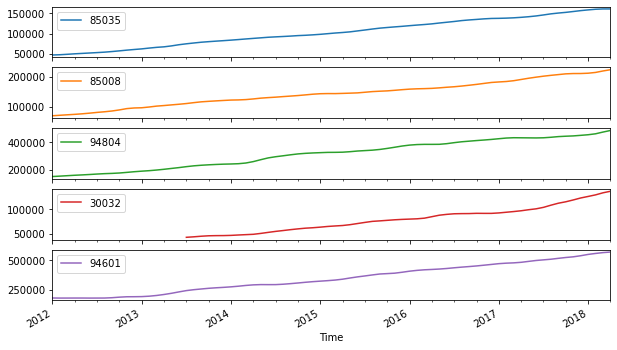

In [93]:
plot_value(bestRetZip, 'RegionName', [85035, 85008, 94804, 30032, 94601]).plot(
    figsize = (10,6), subplots=True, legend=True)
plt.show()
# Similar to the initial graph that includes data from all the zipcodes, the best five cities exhibit a positive
# upward trend. 

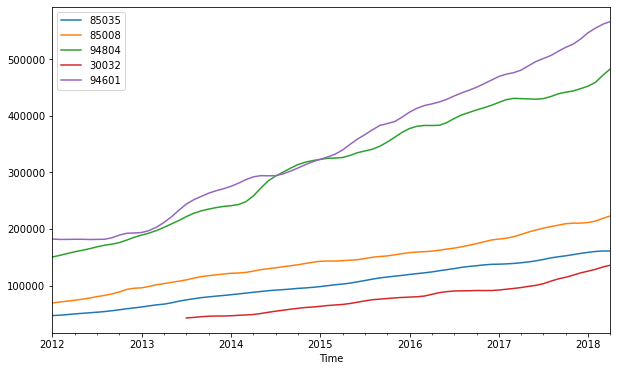

In [274]:
plot_value(bestRetZip, 'RegionName', [85035, 85008, 94804, 30032, 94601]).plot(
    figsize = (10,6), subplots=False, legend=True)
plt.show();

### Trends and Analysis

In [95]:
# Creating a pandas series to house rolling mean values for zipcode
roll_mean1 = bestRetZip.loc[bestRetZip['RegionName'] == 85035]['Value'].rolling(window=7, center=False).mean()
roll_std1 = bestRetZip.loc[bestRetZip['RegionName'] == 85035]['Value'].rolling(window=7, center=False).std()

In [96]:
# Creating a pandas series to house rolling mean values for zipcode
roll_mean2 = bestRetZip.loc[bestRetZip['RegionName'] == 85008]['Value'].rolling(window=7, center=False).mean()
roll_std2 = bestRetZip.loc[bestRetZip['RegionName'] == 85008]['Value'].rolling(window=7, center=False).std()

In [97]:
# Creating a pandas series to house rolling mean values for zipcode
roll_mean3 = bestRetZip.loc[bestRetZip['RegionName'] == 94804]['Value'].rolling(window=7, center=False).mean()
roll_std3 = bestRetZip.loc[bestRetZip['RegionName'] == 94804]['Value'].rolling(window=7, center=False).std()

In [98]:
# Creating a pandas series to house rolling mean values for zipcode
roll_mean4 = bestRetZip.loc[bestRetZip['RegionName'] == 30032]['Value'].rolling(window=7, center=False).mean()
roll_std4 = bestRetZip.loc[bestRetZip['RegionName'] == 30032]['Value'].rolling(window=7, center=False).std()

In [99]:
# Creating a pandas series to house rolling mean values for zipcode
roll_mean5 = bestRetZip.loc[bestRetZip['RegionName'] == 94601]['Value'].rolling(window=7, center=False).mean()
roll_std5 = bestRetZip.loc[bestRetZip['RegionName'] == 94601]['Value'].rolling(window=7, center=False).std()

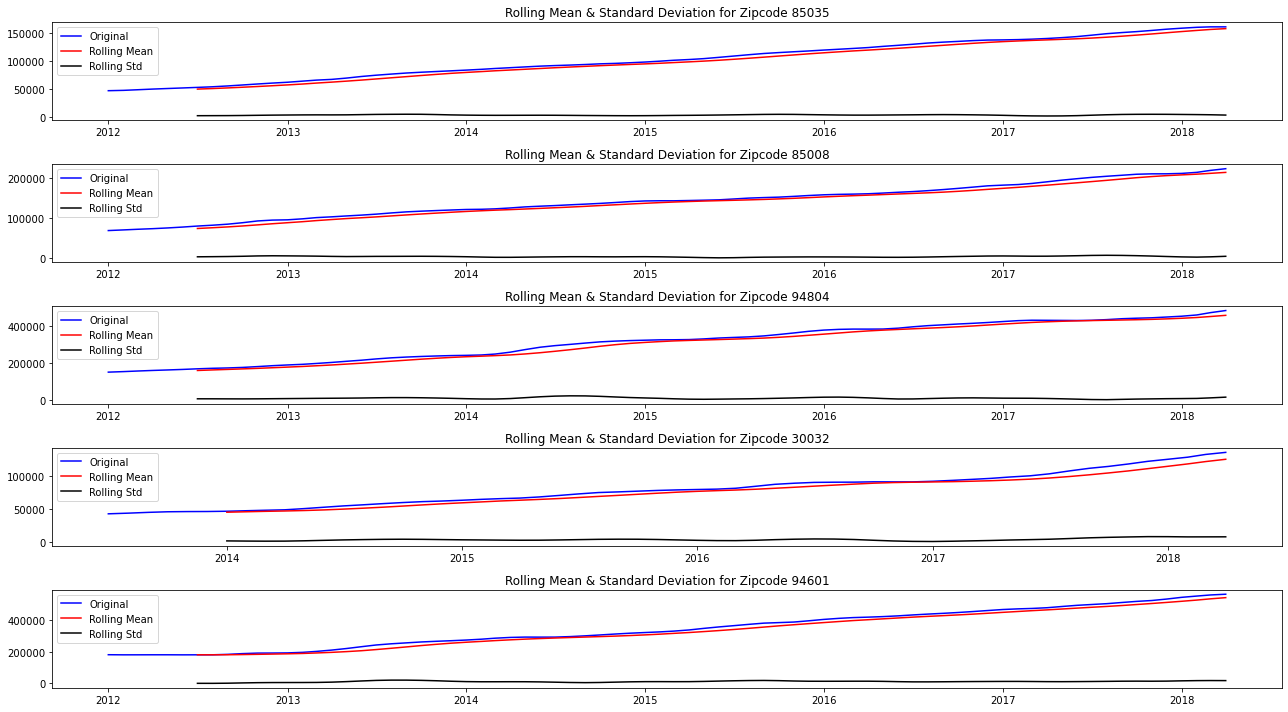

In [100]:
# Creating line plots for five zipcodes
fig, axs = plt.subplots(5, figsize=(18,10))
axs[0].plot(bestRetZip.loc[bestRetZip['RegionName'] == 85035]['Value'], color='blue',label='Original')
axs[0].plot(roll_mean1, color='red', label='Rolling Mean')
axs[0].plot(roll_std1, color='black', label = 'Rolling Std')
axs[0].legend(loc='best')
axs[0].set_title('Rolling Mean & Standard Deviation for Zipcode 85035')
axs[1].plot(bestRetZip.loc[bestRetZip['RegionName'] == 85008]['Value'], color='blue',label='Original')
axs[1].plot(roll_mean2, color='red', label='Rolling Mean')
axs[1].plot(roll_std2, color='black', label = 'Rolling Std')
axs[1].legend(loc='best')
axs[1].set_title('Rolling Mean & Standard Deviation for Zipcode 85008')
axs[2].plot(bestRetZip.loc[bestRetZip['RegionName'] == 94804]['Value'], color='blue',label='Original')
axs[2].plot(roll_mean3, color='red', label='Rolling Mean')
axs[2].plot(roll_std3, color='black', label = 'Rolling Std')
axs[2].legend(loc='best')
axs[2].set_title('Rolling Mean & Standard Deviation for Zipcode 94804')
axs[3].plot(bestRetZip.loc[bestRetZip['RegionName'] == 30032]['Value'], color='blue',label='Original')
axs[3].plot(roll_mean4, color='red', label='Rolling Mean')
axs[3].plot(roll_std4, color='black', label = 'Rolling Std')
axs[3].legend(loc='best')
axs[3].set_title('Rolling Mean & Standard Deviation for Zipcode 30032')
axs[4].plot(bestRetZip.loc[bestRetZip['RegionName'] == 94601]['Value'], color='blue',label='Original')
axs[4].plot(roll_mean5, color='red', label='Rolling Mean')
axs[4].plot(roll_std5, color='black', label = 'Rolling Std')
axs[4].legend(loc='best')
axs[4].set_title('Rolling Mean & Standard Deviation for Zipcode 94601')
fig.tight_layout()

plt.show()

Across all five zipcodes, the standard deviation appears to remain constant. However, as the upward linear rolling means show, all five are not stationary.

### Mitigating Trends & Addressing Stationarity

#### Creating Monthly Percent Return Column

In [101]:
# Creating separate dataframes for each zipcode
_85035 = pd.DataFrame(bestRetZip.loc[bestRetZip['RegionName']== 85035]['Value'])
_85008 = pd.DataFrame(bestRetZip.loc[bestRetZip['RegionName']== 85008]['Value'])
_94601 = pd.DataFrame(bestRetZip.loc[bestRetZip['RegionName']== 94601]['Value'])
_94804 = pd.DataFrame(bestRetZip.loc[bestRetZip['RegionName']== 94804]['Value'])
_30032 = pd.DataFrame(bestRetZip.loc[bestRetZip['RegionName']== 30032]['Value'])

In [102]:
#Creating a column of percent change monthly
def perc_column(df):
    """Takes in dataframe and creates column called 'Percent' that tracks changes in value monthly
    
    Parameters:
    df: pandas DataFrame"""
    df['Percent'] = df.pct_change()
    return df

In [103]:
#Updating each zipcode's dataframe to include monthly percent change in value
_85035 = perc_column(_85035)
_85008 = perc_column(_85008)
_94601 = perc_column(_94601)
_94804 = perc_column(_94804)
_30032 = perc_column(_30032)

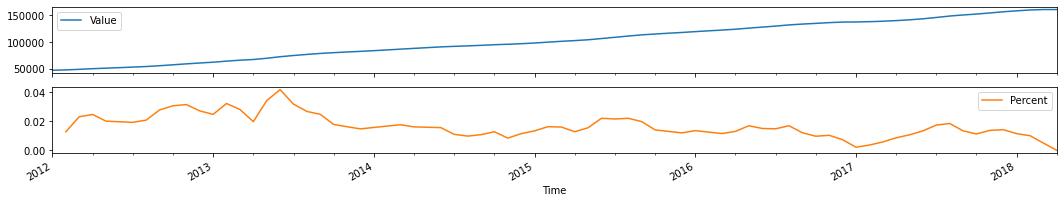

In [104]:
#Comparing the original time series against new time series 
_85035.plot(figsize = (18,3), subplots=True, legend=True)
fig.tight_layout()
plt.show()

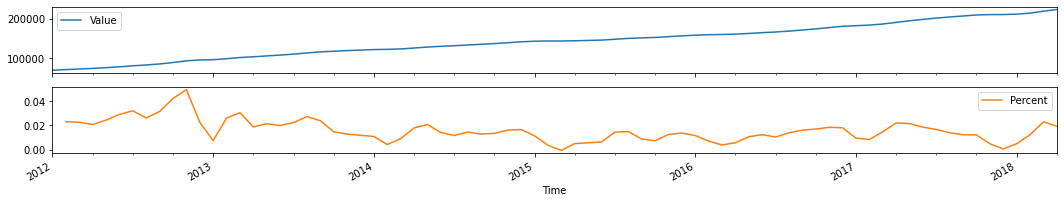

In [105]:
#Comparing the original time series against new time series 
_85008.plot(figsize = (18,3), subplots=True, legend=True)
fig.tight_layout()
plt.show()

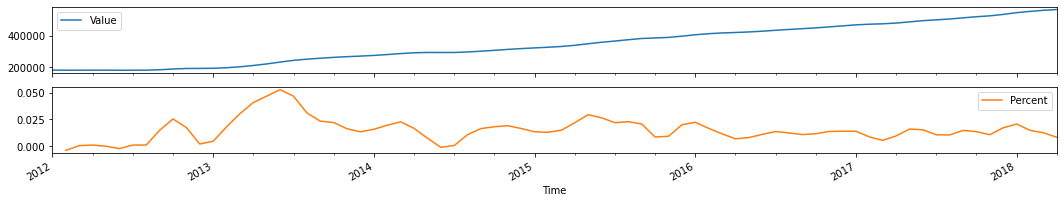

In [106]:
#Comparing the original time series against new time series 
_94601.plot(figsize = (18,3), subplots=True, legend=True)
fig.tight_layout()
plt.show()

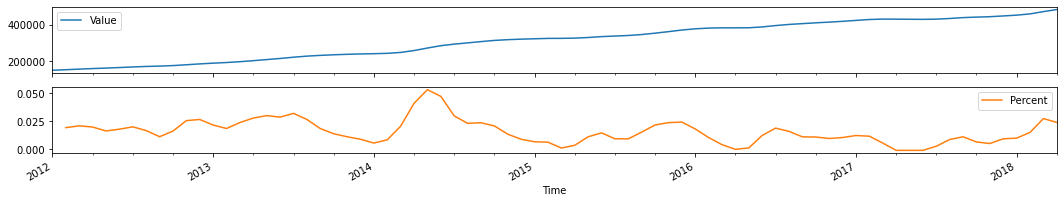

In [107]:
#Comparing the original time series against new time series 
_94804.plot(figsize = (18,3), subplots=True, legend=True)
fig.tight_layout()
plt.show()

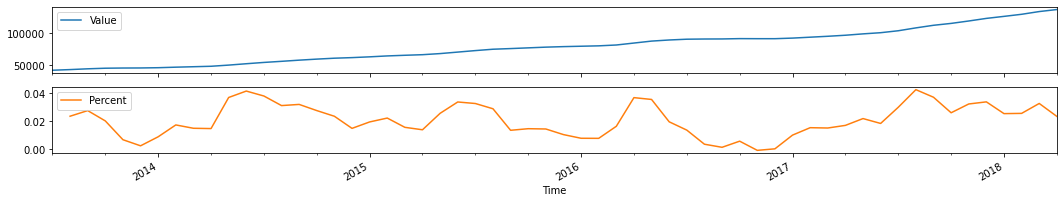

In [108]:
#Comparing the original time series against new time series 
_30032.plot(figsize = (18,3), subplots=True, legend=True)
fig.tight_layout()
plt.show()

By looking at the monthly percent change of the zipcode's median value, the upward linear trend of the original trend is starting to be addressed.

#### Performing Dickey-Fuller Test on Percent Column

In [109]:
def stationarity_check(TS, column):
    """Takes in TimeSeries DataFrame and column"""
    
    # Calculate rolling statistics
    roll_mean = TS[column].rolling(window=8, center=False).mean()
    roll_std = TS[column].rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(TS[column][1:])
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(TS[column], color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [110]:
bestRetZip['RegionName'].unique()

array([85008, 94601, 94804, 85035, 30032])

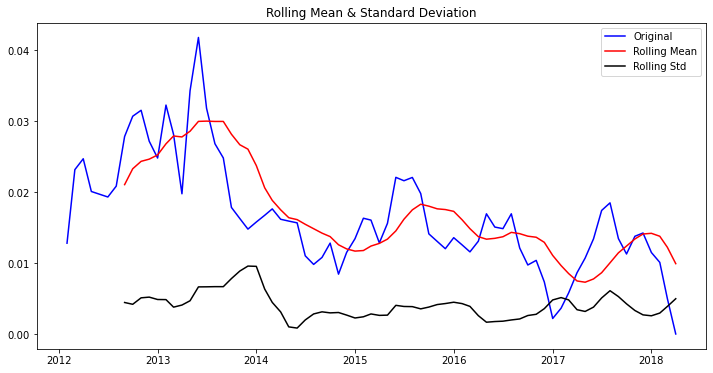

Results of Dickey-Fuller Test: 

Test Statistic                 -1.318978
p-value                         0.620446
#Lags Used                      4.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [111]:
stationarity_check(_85035, 'Percent')

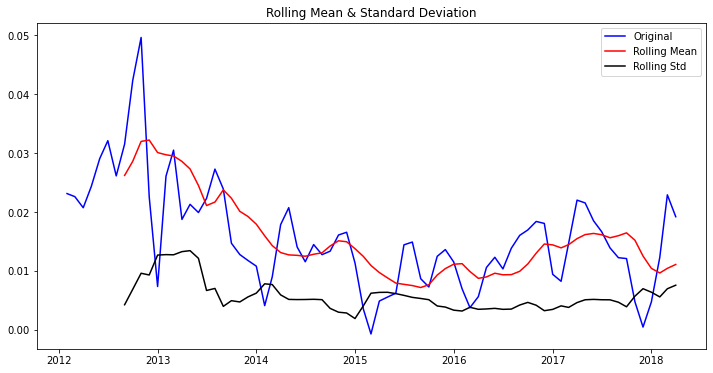

Results of Dickey-Fuller Test: 

Test Statistic                 -2.065996
p-value                         0.258406
#Lags Used                      7.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64


In [112]:
stationarity_check(_85008, 'Percent')

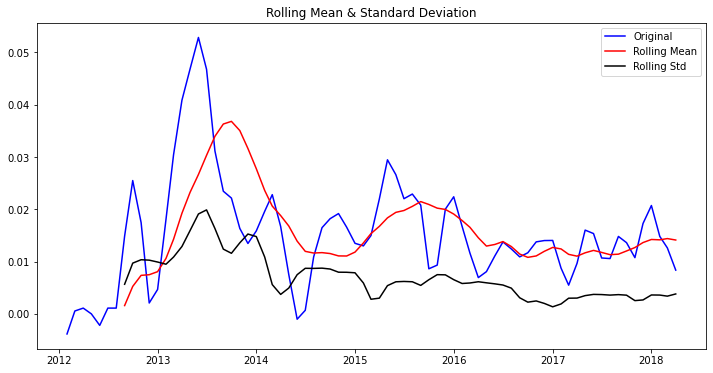

Results of Dickey-Fuller Test: 

Test Statistic                 -2.930218
p-value                         0.041945
#Lags Used                      8.000000
Number of Observations Used    66.000000
Critical Value (1%)            -3.533560
Critical Value (5%)            -2.906444
Critical Value (10%)           -2.590724
dtype: float64


In [113]:
stationarity_check(_94601, 'Percent')

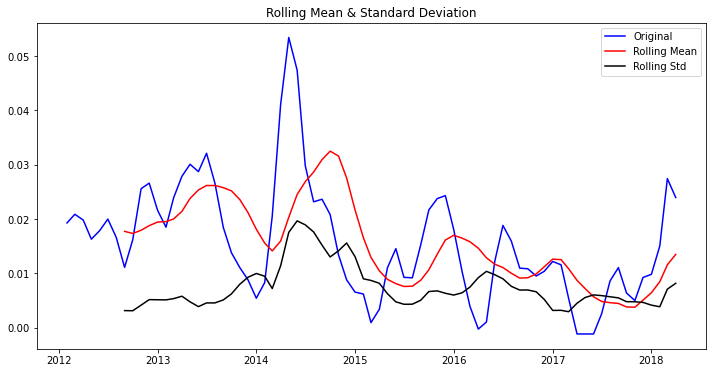

Results of Dickey-Fuller Test: 

Test Statistic                 -3.362850
p-value                         0.012292
#Lags Used                      3.000000
Number of Observations Used    71.000000
Critical Value (1%)            -3.526005
Critical Value (5%)            -2.903200
Critical Value (10%)           -2.588995
dtype: float64


In [114]:
stationarity_check(_94804, 'Percent')

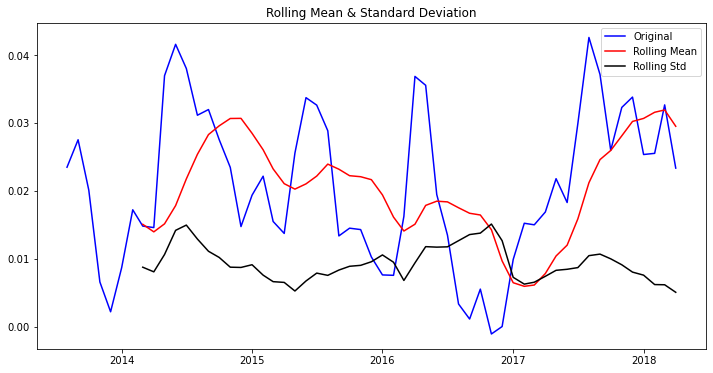

Results of Dickey-Fuller Test: 

Test Statistic                 -3.340207
p-value                         0.013174
#Lags Used                      3.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


In [115]:
stationarity_check(_30032, 'Percent')

Three out of the five zipcodes are stationary according to the Dickey-Fuller Test. Zipcodes 85035 and 85008 exhibit a slight downward linear trajectory. 

#### Decomposition

In [116]:
def decompose(df):
    """Takes a pandas DataFrame and plots the trend, seasonality, and residuals of time series
    
    Parameter:
    df: pandas DataFrame"""
    
    decomposition = seasonal_decompose(df['Percent'][1:])
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(df['Percent'][1:], label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()
    
    return None

In [117]:
bestRetZip['RegionName'].unique()

array([85008, 94601, 94804, 85035, 30032])

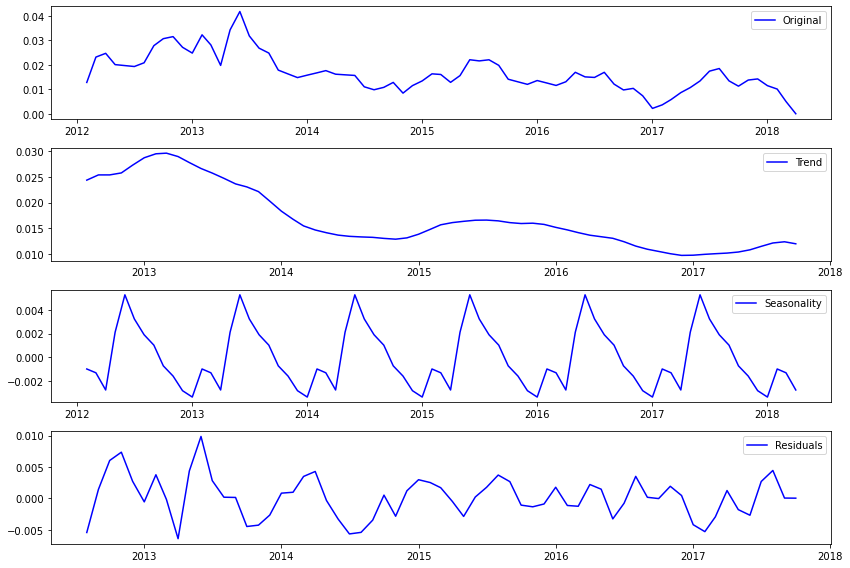

In [118]:
decompose(_85035)

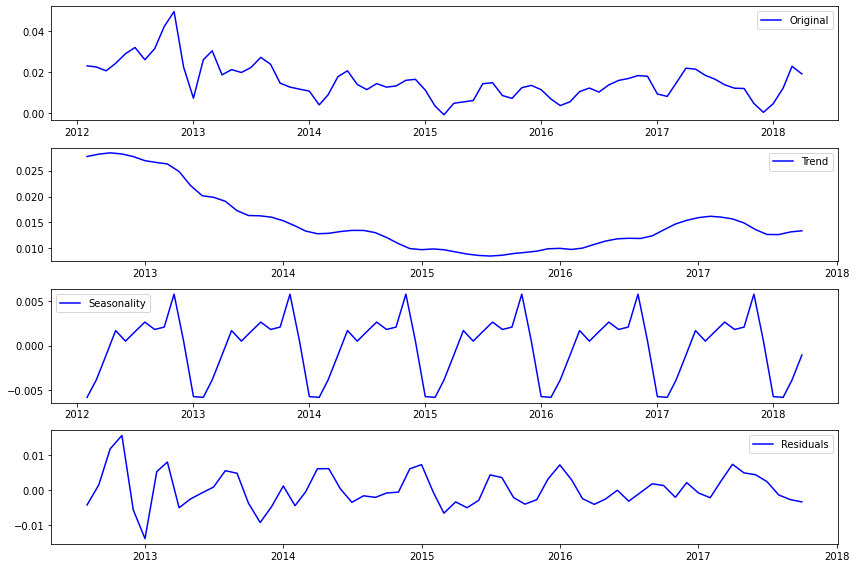

In [119]:
decompose(_85008)

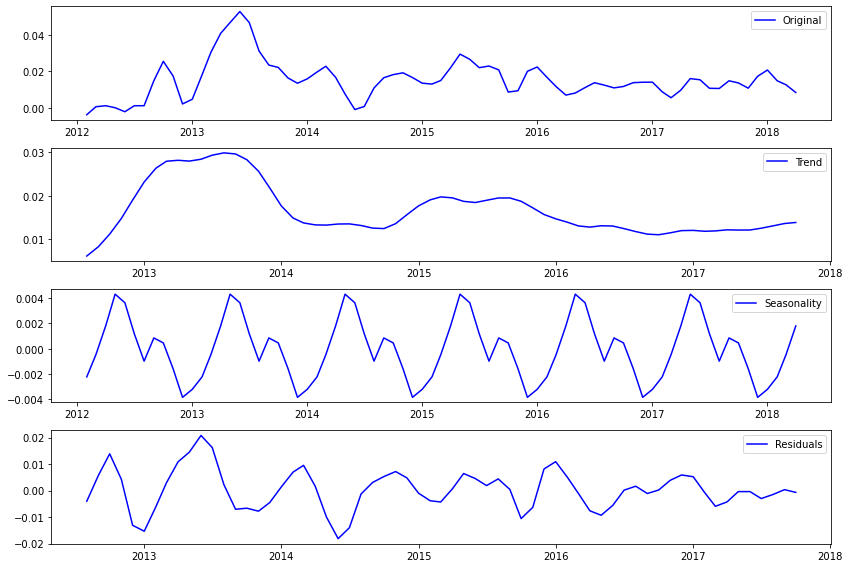

In [120]:
decompose(_94601)

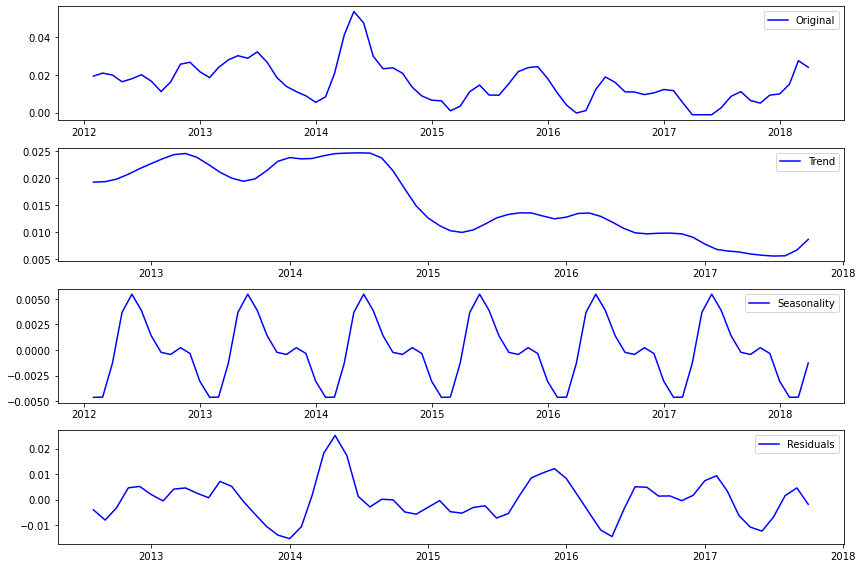

In [121]:
decompose(_94804)

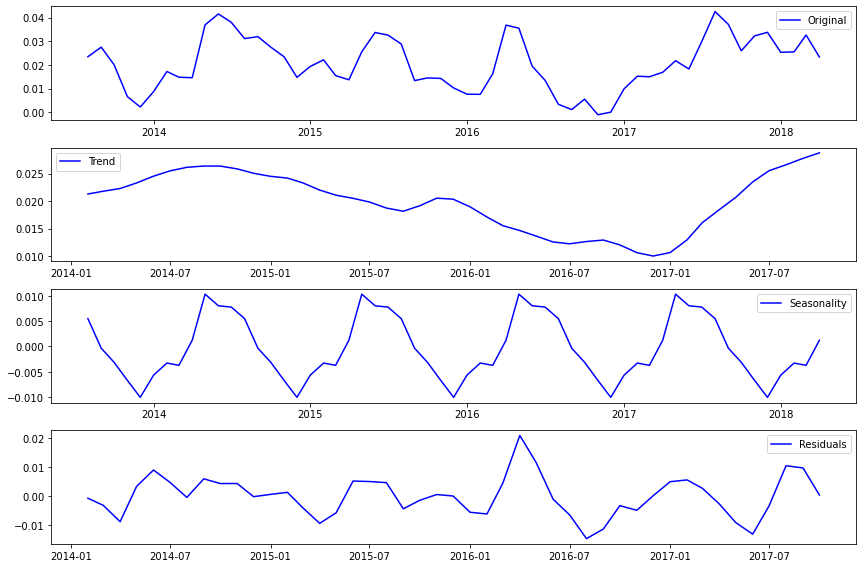

In [122]:
decompose(_30032)

As we can see with the decompositions of each zipcode's monthly percent return, there are varying degrees of trends and seasonality. In order to further arrive to stationary time series, I will perform several transformations on the dataframes such as log transformation, subtracting rolling means, and percentage change between the differences.

#### Transformations

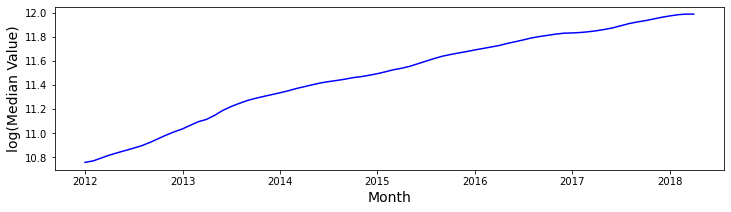

In [123]:
# For all five zipcodes, I created a new column called 'Value Log' to store the logged values
# of the median prices of the zipcodes. Additionally I plotted these values
_85035['Value Log'] = np.log(_85035['Value'])
log_85035 = np.log(_85035['Value'])
fig = plt.figure(figsize=(12,3))
plt.plot(log_85035, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Median Value)', fontsize=14)
plt.show()


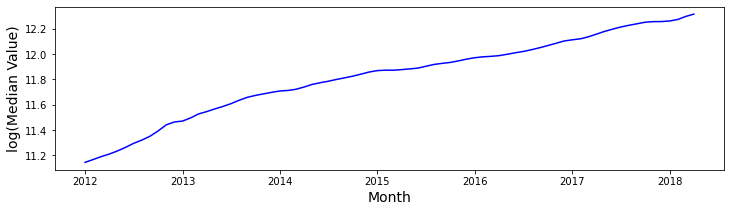

In [124]:
_85008['Value Log'] = np.log(_85008['Value'])
log_85008 = np.log(_85008['Value'])
fig = plt.figure(figsize=(12,3))
plt.plot(log_85008, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Median Value)', fontsize=14)
plt.show()

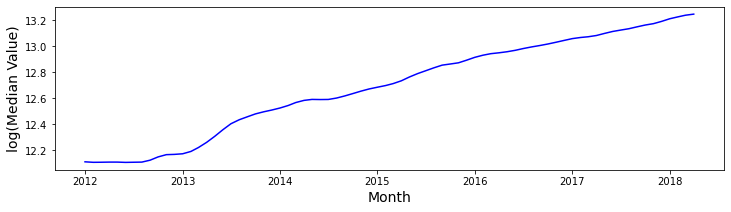

In [125]:
_94601['Value Log'] = np.log(_94601['Value'])
log_94601 = np.log(_94601['Value'])
fig = plt.figure(figsize=(12,3))
plt.plot(log_94601, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Median Value)', fontsize=14)
plt.show()

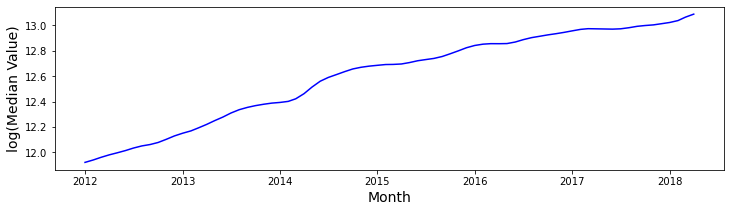

In [126]:
_94804['Value Log'] = np.log(_94804['Value'])
log_94804 = np.log(_94804['Value'])
fig = plt.figure(figsize=(12,3))
plt.plot(log_94804, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Median Value)', fontsize=14)
plt.show()

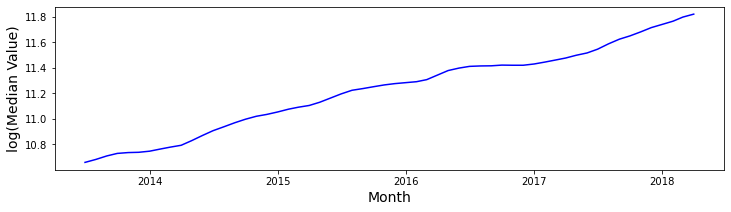

In [127]:
_30032['Value Log'] = np.log(_30032['Value'])
log_30032 = np.log(_30032['Value'])
fig = plt.figure(figsize=(12,3))
plt.plot(log_30032, color='blue')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Median Value)', fontsize=14)
plt.show()

In [128]:
# I created a series for each zipcode to store the rolling means value of the logged values. 
# These series will be used to substract from the logged values
roll_85035 = _85035['Value Log'].rolling(window=6).mean()
roll_85008 = _85008['Value Log'].rolling(window=6).mean()
roll_94601 = _94601['Value Log'].rolling(window=6).mean()
roll_30032 = _30032['Value Log'].rolling(window=6).mean()
roll_94804 = _94804['Value Log'].rolling(window=6).mean()

In [129]:
# I subtracted the rolling means values from the logged values
_85035['Log Minus Roll'] = _85035['Value Log'] - roll_85035
_85008['Log Minus Roll'] = _85008['Value Log'] - roll_85008
_94601['Log Minus Roll'] = _94601['Value Log'] - roll_94601
_30032['Log Minus Roll'] = _30032['Value Log'] - roll_30032
_94804['Log Minus Roll'] = _94804['Value Log'] - roll_94804

In [130]:
# Calculating the percent difference between each month's rolls means subtracted log values
_85035['Percent Log'] = _85035['Log Minus Roll'].pct_change()
_85008['Percent Log'] = _85008['Log Minus Roll'].pct_change()
_94601['Percent Log'] = _94601['Log Minus Roll'].pct_change()
_30032['Percent Log'] = _30032['Log Minus Roll'].pct_change()
_94804['Percent Log'] = _94804['Log Minus Roll'].pct_change()

Below I double check to see the stationarity of all zipcodes as well as the rolling means and standard deviations

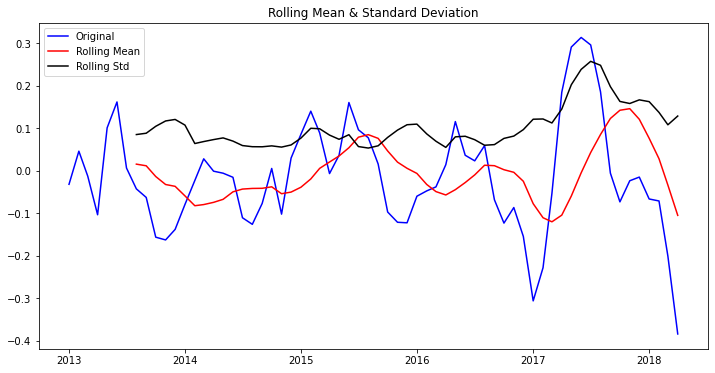

Results of Dickey-Fuller Test: 

Test Statistic                 -3.614166
p-value                         0.005496
#Lags Used                      1.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [131]:
first = _85035.loc[_85035.index >= '2013-01-01']
stationarity_check(first, 'Percent Log')

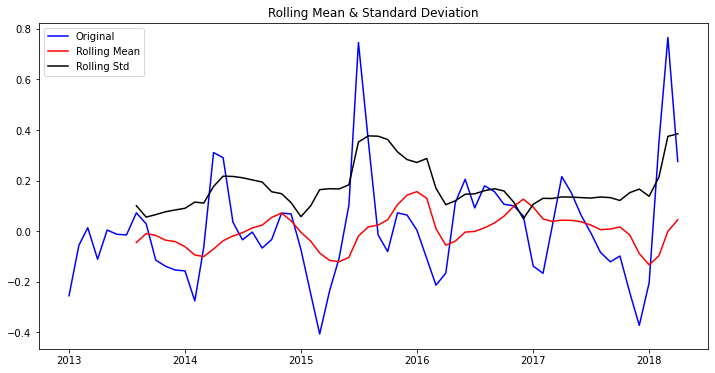

Results of Dickey-Fuller Test: 

Test Statistic                -6.680703e+00
p-value                        4.349685e-09
#Lags Used                     1.000000e+00
Number of Observations Used    6.100000e+01
Critical Value (1%)           -3.542413e+00
Critical Value (5%)           -2.910236e+00
Critical Value (10%)          -2.592745e+00
dtype: float64


In [132]:
second = _85008.loc[_85008.index >= '2013-01-01']
stationarity_check(second, 'Percent Log')

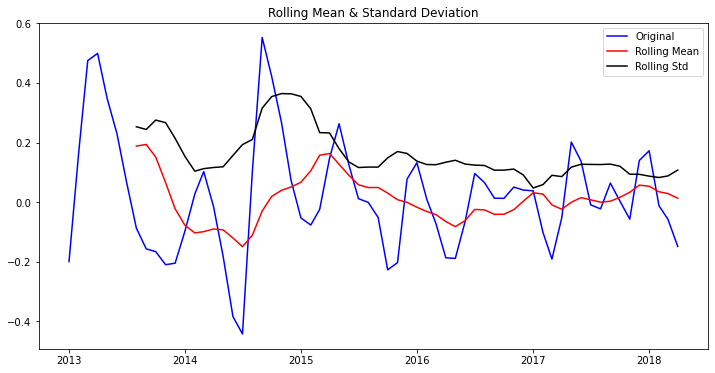

Results of Dickey-Fuller Test: 

Test Statistic                 -3.758623
p-value                         0.003360
#Lags Used                      4.000000
Number of Observations Used    58.000000
Critical Value (1%)            -3.548494
Critical Value (5%)            -2.912837
Critical Value (10%)           -2.594129
dtype: float64


In [133]:
third = _94601.loc[_94601.index >= '2013-01-01']
stationarity_check(third, 'Percent Log')

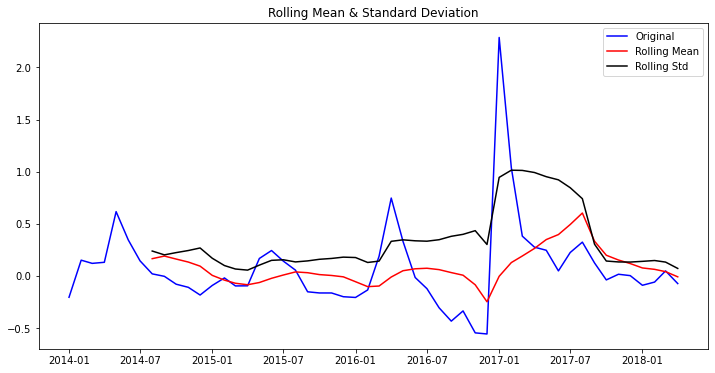

Results of Dickey-Fuller Test: 

Test Statistic                 -4.744474
p-value                         0.000069
#Lags Used                      0.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [134]:
fourth = _30032.loc[_30032.index >= '2014-01-01']
stationarity_check(fourth, 'Percent Log')

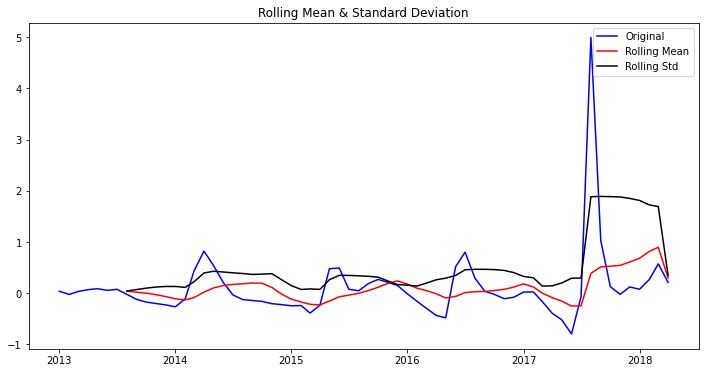

Results of Dickey-Fuller Test: 

Test Statistic                -5.974384e+00
p-value                        1.902764e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.200000e+01
Critical Value (1%)           -3.540523e+00
Critical Value (5%)           -2.909427e+00
Critical Value (10%)          -2.592314e+00
dtype: float64


In [135]:
fifth = _94804.loc[_94804.index >= '2013-01-01']
stationarity_check(fifth, 'Percent Log')

In [136]:
bestRetZip['RegionName'].unique()

array([85008, 94601, 94804, 85035, 30032])

### Initial Random Walk Model

In [137]:
# White noise error term
error = np.random.normal(0, 10, len(first['Percent Log']))

# Define random walk
def random_walk(start, error):        
    Y_0 = start
    cum_error = np.cumsum(error)
    Y = cum_error + Y_0 
    return Y

shares_value = random_walk(1000, error)

shares_series = first['Percent Log']

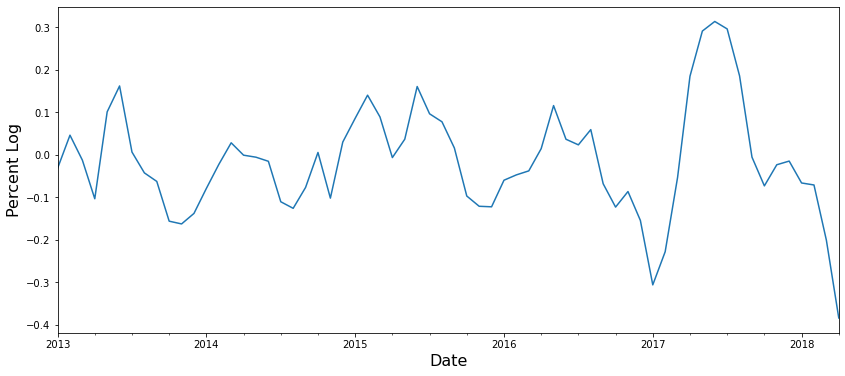

In [138]:
ax = shares_series.plot(figsize=(14,6))
ax.set_ylabel('Percent Log', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
plt.show()

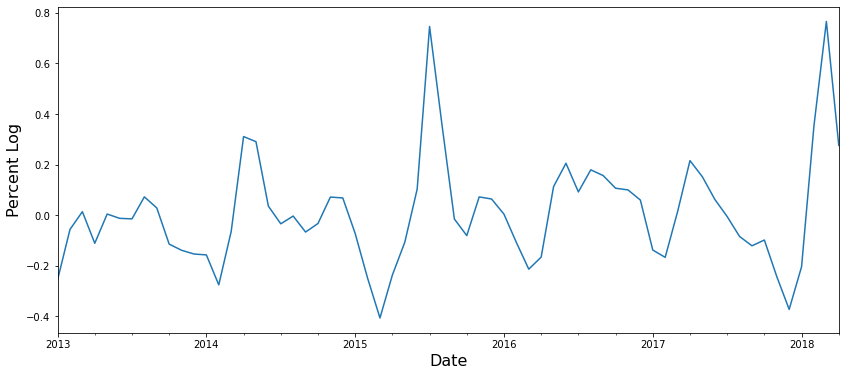

In [139]:
shares_value2 = random_walk(1000, error)
shares_series2 = second['Percent Log']

ax = shares_series2.plot(figsize=(14,6))
ax.set_ylabel('Percent Log', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
plt.show()

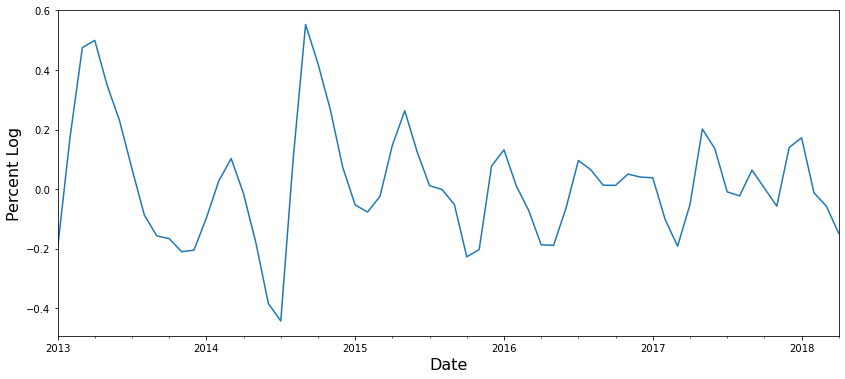

In [140]:
shares_value3 = random_walk(1000, error)
shares_series3 = third['Percent Log']

ax = shares_series3.plot(figsize=(14,6))
ax.set_ylabel('Percent Log', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
plt.show()

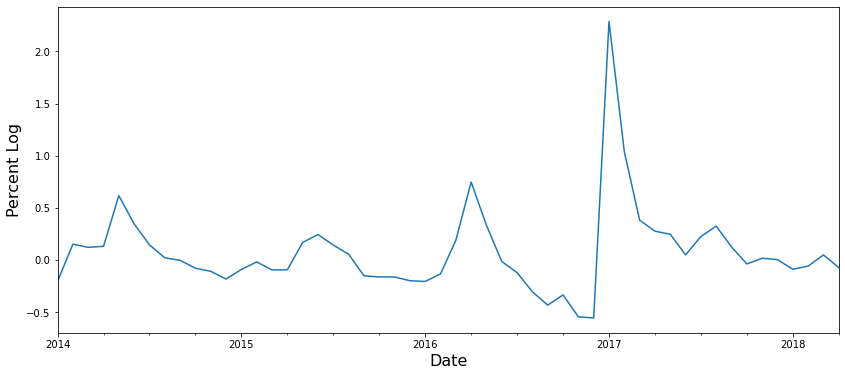

In [141]:
shares_value4 = random_walk(1000, error)
shares_series4 = fourth['Percent Log']

ax = shares_series4.plot(figsize=(14,6))
ax.set_ylabel('Percent Log', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
plt.show()

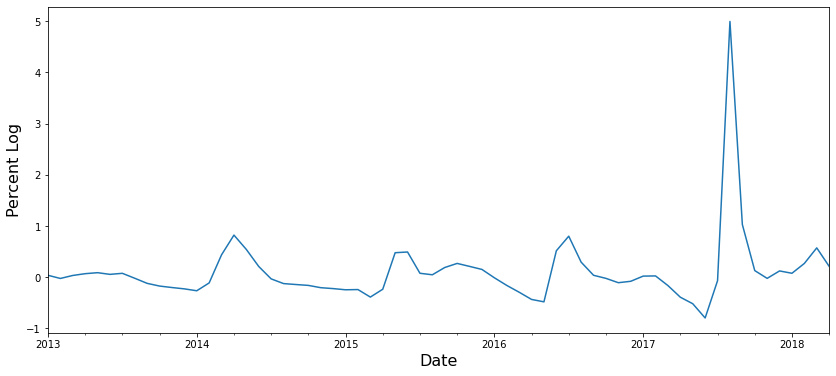

In [142]:
shares_value5 = random_walk(1000, error)
shares_series5 = fifth['Percent Log']

ax = shares_series5.plot(figsize=(14,6))
ax.set_ylabel('Percent Log', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
plt.show()

The random walk models do not necessarily provide more insight into the time series we had not already seen in previous analyses. 

#### Autocorrelation and Partial Autocorrelation

Text(0.5, 1.0, 'Zipcode 85035')

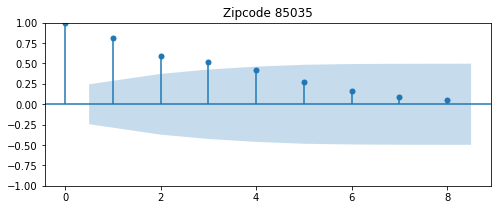

In [143]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(first['Percent'],ax=ax, lags=8);
ax.set_title('Zipcode 85035')

Because the plot starts at lag-zero, there are three stastially significant peaks outside the confidence interval.

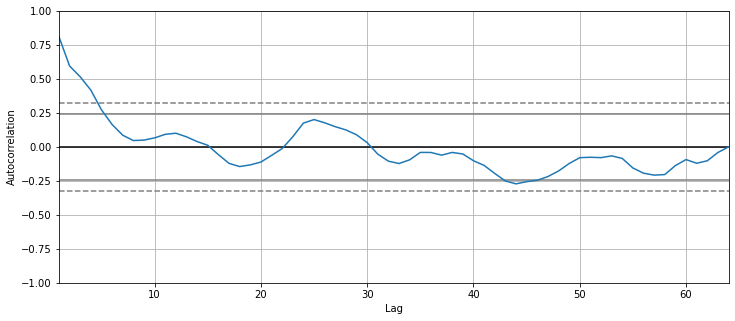

In [144]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(first['Percent']);

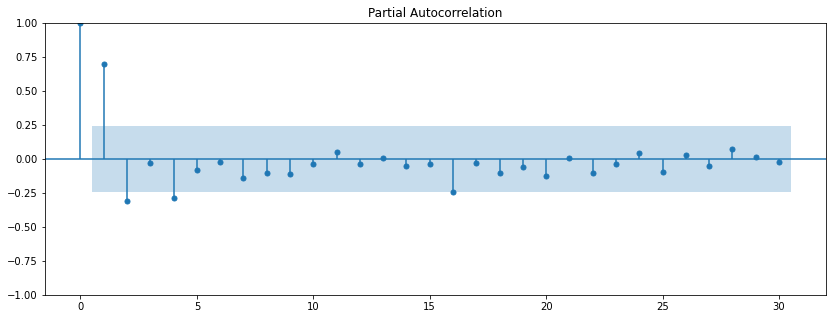

In [145]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(first['Percent Log'], lags=30, method='ywm');

Text(0.5, 1.0, 'Zipcode 85035')

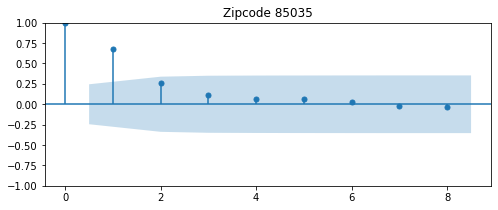

In [146]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(second['Percent'],ax=ax, lags=8);
ax.set_title('Zipcode 85035')

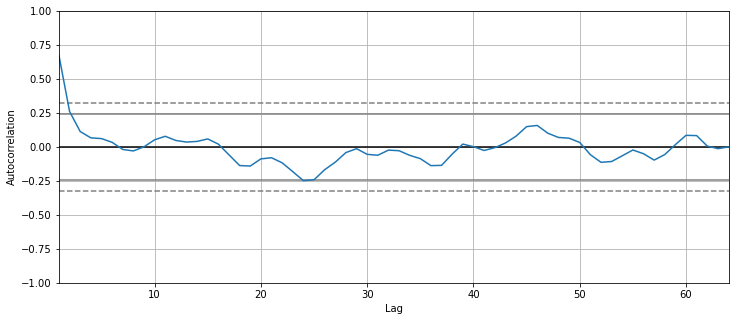

In [147]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(second['Percent']);

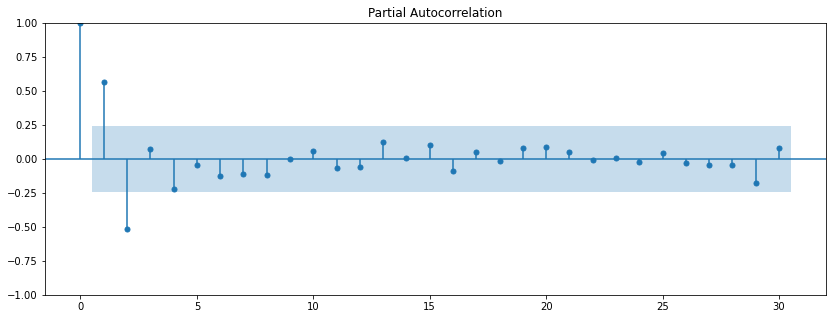

In [148]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(second['Percent Log'], lags=30, method='ywm');

Text(0.5, 1.0, 'Zipcode 94601')

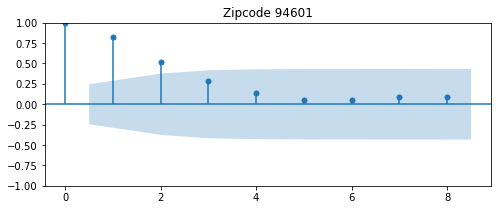

In [149]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(third['Percent'],ax=ax, lags=8);
ax.set_title('Zipcode 94601')

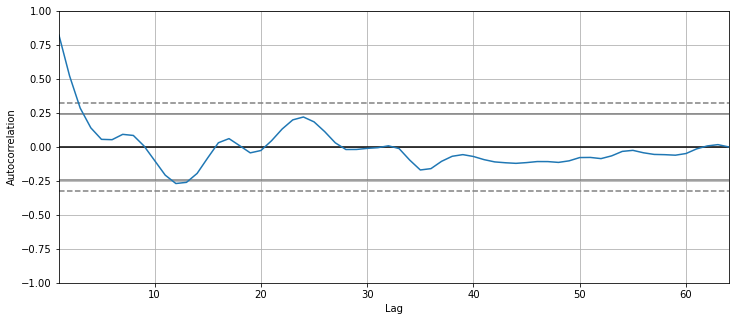

In [150]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(third['Percent']);

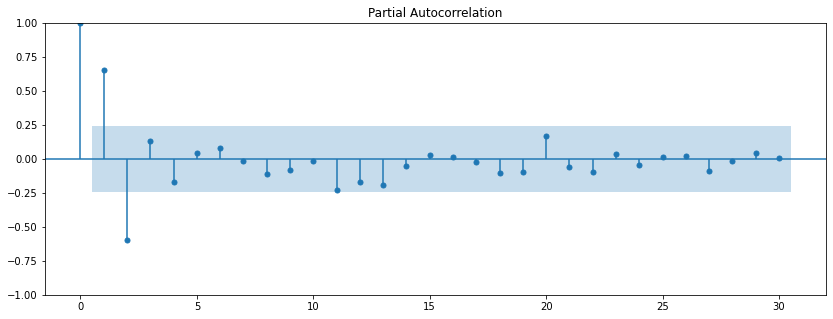

In [151]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(third['Percent Log'], lags=30, method='ywm');

Text(0.5, 1.0, 'Zipcode 30032')

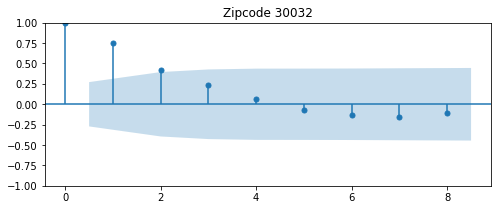

In [152]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(fourth['Percent'],ax=ax, lags=8);
ax.set_title('Zipcode 30032')

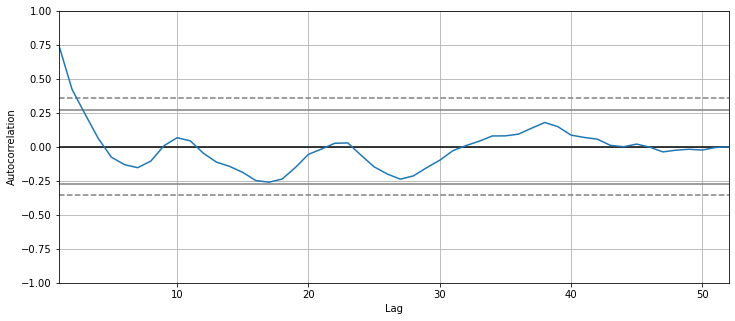

In [153]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(fourth['Percent']);

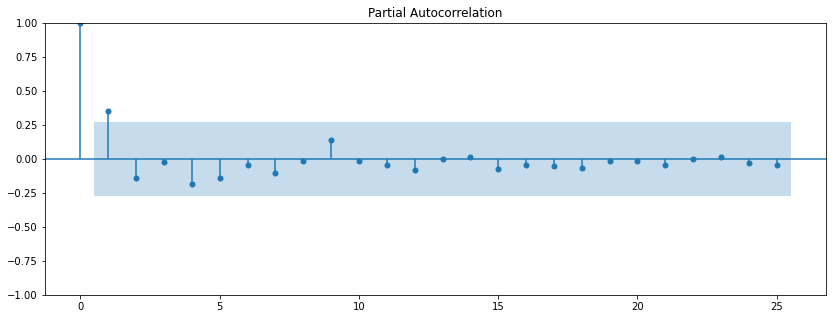

In [154]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(fourth['Percent Log'], lags=25, method='ywm');

Text(0.5, 1.0, 'Zipcode 94804')

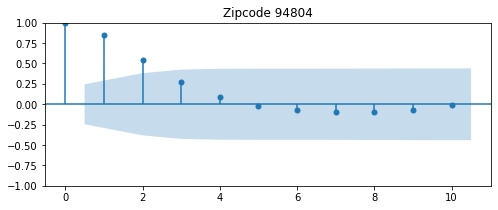

In [155]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(fifth['Percent'],ax=ax, lags=10);
ax.set_title('Zipcode 94804')

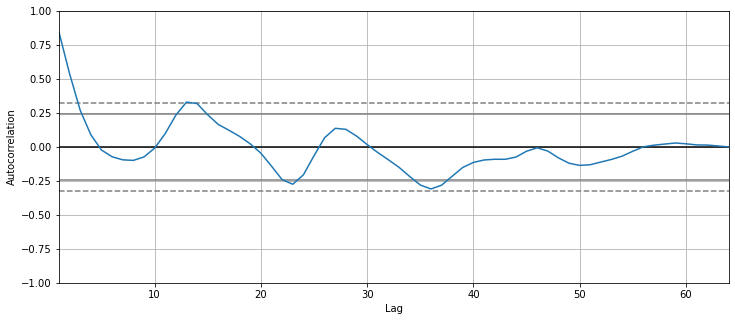

In [156]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(fifth['Percent']);

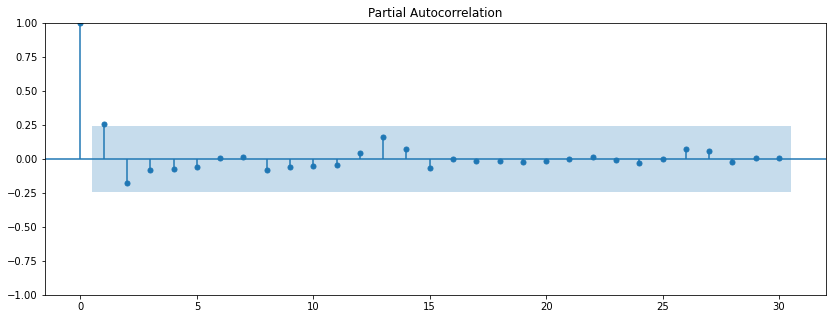

In [157]:
rcParams['figure.figsize'] = 14, 5
plot_pacf(fifth['Percent Log'], lags=30, method='ywm');

#### Train-Test Split

In [158]:
end_zip1 = round(first['Percent'].shape[0] *.8)
train_85035 = first['Percent'][:end_zip1]

end_zip2 = round(second['Percent'].shape[0] *.8)
train_85008 = second['Percent'][:end_zip2]

end_zip3 = round(third['Percent'].shape[0] *.8)
train_94601 = third['Percent'][:end_zip3]

end_zip4 = round(fourth['Percent'].shape[0] *.8)
train_30032 = fourth['Percent'][:end_zip4]

end_zip5 = round(fifth['Percent'].shape[0] *.8)
train_94804 = fifth['Percent'][:end_zip5]

In [159]:
test_85035 = first['Percent'][end_zip1:]
test_85008 = second['Percent'][end_zip2:]
test_94601 = third['Percent'][end_zip3:]
test_30032 = fourth['Percent'][end_zip4:]
test_94804 = fifth['Percent'][end_zip5:]

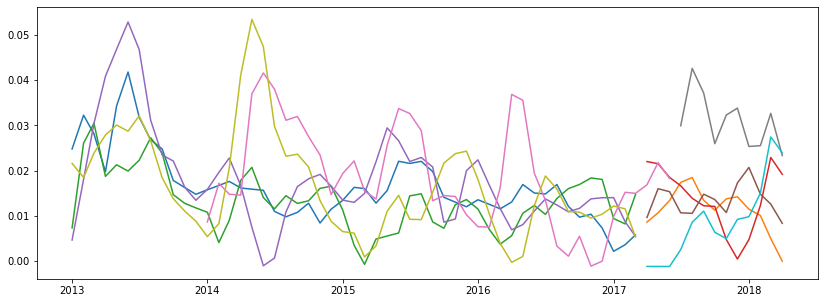

In [160]:
fig, ax = plt.subplots()
ax.plot(train_85035)
ax.plot(test_85035)

ax.plot(train_85008)
ax.plot(test_85008)

ax.plot(train_94601)
ax.plot(test_94601)

ax.plot(train_30032)
ax.plot(test_30032)

ax.plot(train_94804)
ax.plot(test_94804)

#### Second Random Walk

<AxesSubplot:xlabel='Time'>

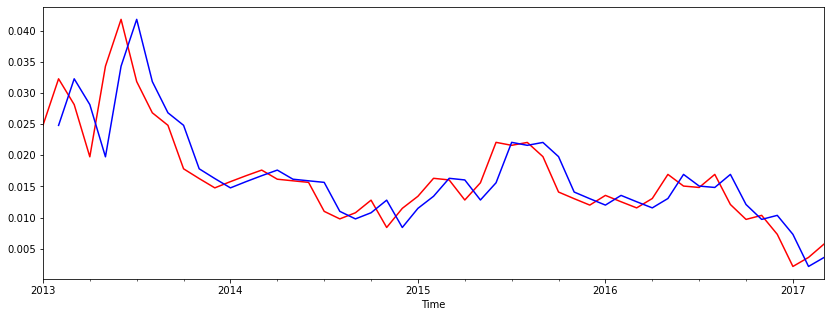

In [161]:
random_walk1 = train_85035.shift(1)

fig, ax = plt.subplots()

train_85035. plot(ax = ax, c ='r', label = 'original')
random_walk1.plot(ax = ax, c ='b', label = 'shifted')

In [162]:
residuals1 = random_walk1 - train_85035
rmse1 = mean_squared_error(train_85035[1:], random_walk1.dropna(), squared = False)
rmse1

0.0041639430490901215

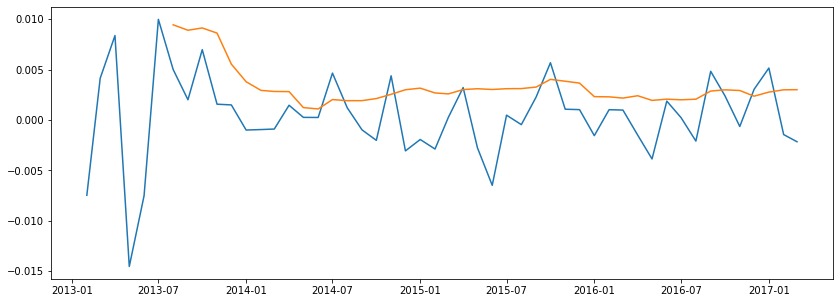

In [163]:
plt.plot(residuals1.index, residuals1)
plt.plot(residuals1.index, residuals1.rolling(7).std())

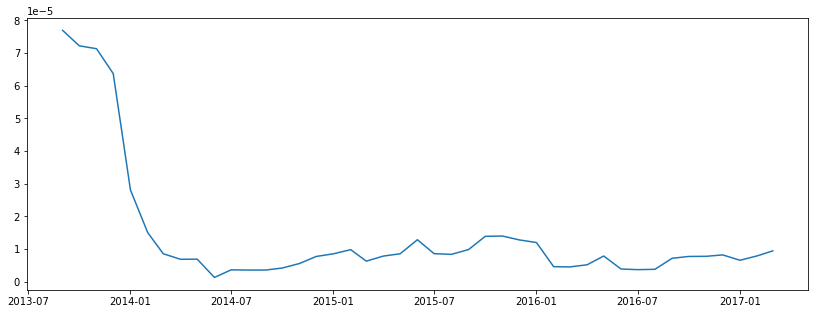

In [164]:
plt.plot(residuals1.index, residuals1.rolling(8).var())

### ARIMA

#### Integration

In [165]:
rw1 = ARIMA(train_85035, order = (0,1,0)).fit()
rw1.predict(typ= 'levels')

2013-01-01    0.000000
2013-02-01    0.024793
2013-03-01    0.032258
2013-04-01    0.028125
2013-05-01    0.019757
2013-06-01    0.034277
2013-07-01    0.041787
2013-08-01    0.031812
2013-09-01    0.026810
2013-10-01    0.024804
2013-11-01    0.017834
2013-12-01    0.016270
2014-01-01    0.014778
2014-02-01    0.015777
2014-03-01    0.016726
2014-04-01    0.017626
2014-05-01    0.016166
2014-06-01    0.015909
2014-07-01    0.015660
2014-08-01    0.011013
2014-09-01    0.009804
2014-10-01    0.010787
2014-11-01    0.012807
2014-12-01    0.008430
2015-01-01    0.011494
2015-02-01    0.013430
2015-03-01    0.016310
2015-04-01    0.016048
2015-05-01    0.012833
2015-06-01    0.015595
2015-07-01    0.022073
2015-08-01    0.021596
2015-09-01    0.022059
2015-10-01    0.019784
2015-11-01    0.014109
2015-12-01    0.013043
2016-01-01    0.012017
2016-02-01    0.013571
2016-03-01    0.012552
2016-04-01    0.011570
2016-05-01    0.013072
2016-06-01    0.016935
2016-07-01    0.015067
2016-08-01 

In [166]:
y_hat_rw1 = rw1.predict(typ = 'levels')
rmse_rw1 = np.sqrt(mean_squared_error(train_85035, y_hat_rw1))
rmse_rw1

0.005389956109309407

#### Autoregression

In [167]:
ar1 = ARIMA(train_85035, order = (1,1,0)).fit()
ar1.predict(typ='levels')

2013-01-01    0.000000
2013-02-01    0.024793
2013-03-01    0.032506
2013-04-01    0.027988
2013-05-01    0.019479
2013-06-01    0.034760
2013-07-01    0.042036
2013-08-01    0.031480
2013-09-01    0.026643
2013-10-01    0.024737
2013-11-01    0.017603
2013-12-01    0.016218
2014-01-01    0.014729
2014-02-01    0.015810
2014-03-01    0.016758
2014-04-01    0.017656
2014-05-01    0.016118
2014-06-01    0.015901
2014-07-01    0.015652
2014-08-01    0.010859
2014-09-01    0.009764
2014-10-01    0.010820
2014-11-01    0.012874
2014-12-01    0.008284
2015-01-01    0.011596
2015-02-01    0.013494
2015-03-01    0.016406
2015-04-01    0.016039
2015-05-01    0.012726
2015-06-01    0.015686
2015-07-01    0.022288
2015-08-01    0.021580
2015-09-01    0.022074
2015-10-01    0.019709
2015-11-01    0.013921
2015-12-01    0.013008
2016-01-01    0.011983
2016-02-01    0.013622
2016-03-01    0.012518
2016-04-01    0.011538
2016-05-01    0.013122
2016-06-01    0.017064
2016-07-01    0.015005
2016-08-01 

In [168]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Percent   No. Observations:                   51
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 203.146
Date:                Fri, 29 Oct 2021   AIC                           -402.293
Time:                        14:15:23   BIC                           -398.469
Sample:                    01-01-2013   HQIC                          -400.837
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.104      0.319      0.750      -0.171       0.238
sigma2      1.731e-05   2.81e-06      6.155      0.000    1.18e-05    2.28e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
print(f'Random Walk AIC: {rw1.aic}')
print(f'AR1 AIC: {ar1.aic}')
# The random walk model produced a lower AIC meaning that it provided a slightly better fit than 
# autoregression model

Random Walk AIC: -404.2353134655142
AR1 AIC: -402.29292348728876


In [170]:
y_hat_ar1 = ar1.predict(typ = 'levels')
rmse_ar1 = np.sqrt(mean_squared_error(train_85035, y_hat_ar1))
print(rmse_ar1)
print(rmse_rw1)
#However, the autoregression model did provide a better root mean squared error score by introducing a lag
# of 1, albeit a small difference.

0.005388221870853018
0.005389956109309407


In [171]:
ar1.arparams

array([0.0332535])

#### Moving Average

In [172]:
ma1 = ARIMA(train_85035, order = (0,0,1)).fit()
y_hat_ma1 = ma1.predict(typ='levels')
y_hat_ma1

2013-01-01    0.016427
2013-02-01    0.020599
2013-03-01    0.024164
2013-04-01    0.019379
2013-05-01    0.016727
2013-06-01    0.030905
2013-07-01    0.025644
2013-08-01    0.021751
2013-09-01    0.020855
2013-10-01    0.019921
2013-11-01    0.014566
2013-12-01    0.017958
2014-01-01    0.013556
2014-02-01    0.018441
2014-03-01    0.014867
2014-04-01    0.018946
2014-05-01    0.013883
2014-06-01    0.018285
2014-07-01    0.014016
2014-08-01    0.013665
2014-09-01    0.012871
2014-10-01    0.014506
2014-11-01    0.014859
2014-12-01    0.010489
2015-01-01    0.017356
2015-02-01    0.012796
2015-03-01    0.019678
2015-04-01    0.013068
2015-05-01    0.016210
2015-06-01    0.015857
2015-07-01    0.022186
2015-08-01    0.015881
2015-09-01    0.022153
2015-10-01    0.014232
2015-11-01    0.016314
2015-12-01    0.013395
2016-01-01    0.015150
2016-02-01    0.014963
2016-03-01    0.014192
2016-04-01    0.013996
2016-05-01    0.015570
2016-06-01    0.017694
2016-07-01    0.013991
2016-08-01 

In [173]:
ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Percent   No. Observations:                   51
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 200.666
Date:                Fri, 29 Oct 2021   AIC                           -395.331
Time:                        14:15:23   BIC                           -389.536
Sample:                    01-01-2013   HQIC                          -393.116
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.002     10.778      0.000       0.013       0.019
ma.L1          0.9279      0.115      8.082      0.000       0.703       1.153
sigma2      2.149e-05   4.35e-06      4.944      0.000     1.3e-05       3e-05
===================================================================================
Ljung-Box (L1) (Q):                  10.88   Jarque-Bera (JB):                19.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             1.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [174]:
rmse_ma1 = np.sqrt(mean_squared_error(train_85035, y_hat_ma1))
rmse_ma1
# By introducing a coefficient of 1 to q (introducing a lag of 1 to the error),
# we lowered our root mean squared error score

0.004898219930202168

In [175]:
print(f'Random Walk AIC: {rw1.aic}')
print(f'AR1 AIC: {ar1.aic}')
print(f'MA1 AIC: {ma1.aic}')
# It also provided us with a lower AIC score

Random Walk AIC: -404.2353134655142
AR1 AIC: -402.29292348728876
MA1 AIC: -395.33105985101986


#### Auto-ARIMA

In [176]:
from pmdarima import auto_arima
auto_arima(train_85035, start_p= 0, start_q= 0, max_p= 8, max_q=3, seasonal = False, Trace = True)

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [177]:
y_hat_test1 = rw1.predict(start = test_85035.index[0], end = test_85035.index[-1], typ = 'levels')

In [178]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [179]:
import itertools
p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]
print('Examples of parameter for SARIMA...')
for i in pdq:
    for s in seasonal_pdq:
        print('SARIMAX: {} x {}'.format(i, s))

Examples of parameter for SARIMA...
SARIMAX: (0, 1, 0) x (0, 1, 0, 52)
SARIMAX: (0, 1, 0) x (0, 1, 1, 52)
SARIMAX: (0, 1, 0) x (1, 1, 0, 52)
SARIMAX: (0, 1, 0) x (1, 1, 1, 52)
SARIMAX: (0, 1, 1) x (0, 1, 0, 52)
SARIMAX: (0, 1, 1) x (0, 1, 1, 52)
SARIMAX: (0, 1, 1) x (1, 1, 0, 52)
SARIMAX: (0, 1, 1) x (1, 1, 1, 52)
SARIMAX: (1, 1, 0) x (0, 1, 0, 52)
SARIMAX: (1, 1, 0) x (0, 1, 1, 52)
SARIMAX: (1, 1, 0) x (1, 1, 0, 52)
SARIMAX: (1, 1, 0) x (1, 1, 1, 52)
SARIMAX: (1, 1, 1) x (0, 1, 0, 52)
SARIMAX: (1, 1, 1) x (0, 1, 1, 52)
SARIMAX: (1, 1, 1) x (1, 1, 0, 52)
SARIMAX: (1, 1, 1) x (1, 1, 1, 52)


In [180]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_85035,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:4.0
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10.0


#### Zipcode 85035

In [181]:
sari_mod1 =SARIMAX(train_85035,order=(0,1,0),
                  seasonal_order=(0,1,0,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

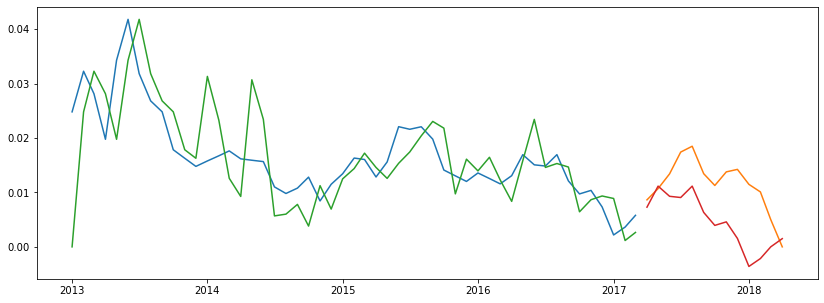

In [182]:
y_hat_train1 = sari_mod1.predict(typ='levels')
y_hat_test_sar1 = sari_mod1.predict(start=test_85035.index[0], end=test_85035.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train_85035)
ax.plot(test_85035)
ax.plot(y_hat_train1)
ax.plot(y_hat_test_sar1)

In [183]:
np.sqrt(mean_squared_error(test_85035, y_hat_test_sar1))

0.008302100748181567

In [184]:
sari_mod =SARIMAX(first['Percent'],order=(0,1,0),seasonal_order=(0,1,1,12),enforce_stationarity=
                  False,enforce_invertibility=False).fit()

In [185]:
forecast1 = sari_mod.forecast(steps = 52)

Text(0.5, 1.0, 'Predicted Return per Month')

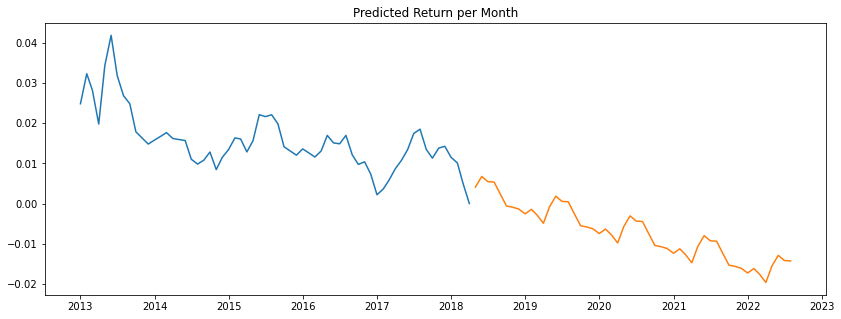

In [186]:
fig, ax = plt.subplots()

ax.plot(first['Percent'])
ax.plot(forecast1)
ax.set_title('Predicted Return per Month')

In [187]:
forecast1df = pd.DataFrame(forecast1)

In [188]:
for value in forecast1df['predicted_mean']: 
    forecast1df['Predicted Value'] = first['Value'][-1] + forecast1df['predicted_mean'] * first['Value'][-1]

In [189]:
forecast1df.head()

,predicted_mean,Predicted Value
2018-05-01,0.004098,161659.751877
2018-06-01,0.006729,162083.343065
2018-07-01,0.005445,161876.577604
2018-08-01,0.005345,161860.580966
2018-09-01,0.002302,161370.558348


#### Zipcode 85008

In [190]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_85008,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:4.0
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10.0


In [191]:
sari_mod2 =SARIMAX(train_85008,order=(0,1,0),
                  seasonal_order=(0,1,0,20),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

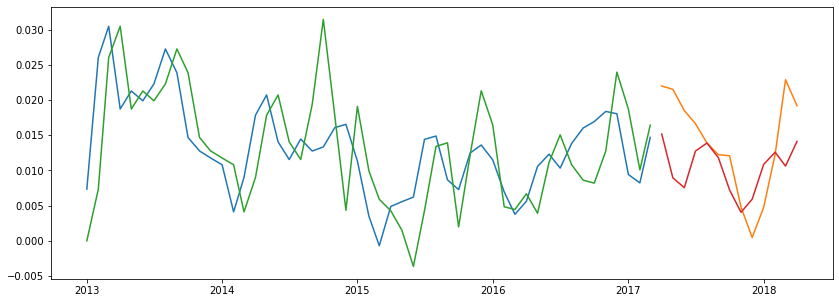

In [192]:
y_hat_train2 = sari_mod2.predict(typ='levels')
y_hat_test_sar2 = sari_mod2.predict(start=test_85008.index[0], end=test_85008.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train_85008)
ax.plot(test_85008)
ax.plot(y_hat_train2)
ax.plot(y_hat_test_sar2)

In [193]:
np.sqrt(mean_squared_error(test_85008, y_hat_test_sar2))

0.006837771918139388

In [194]:
sari_mod2 =SARIMAX(second['Percent'],order=(0,1,0),seasonal_order=(0,1,1,20),enforce_stationarity=
                  False,enforce_invertibility=False).fit()

In [195]:
forecast2 = sari_mod2.forecast(steps = 52)

Text(0.5, 1.0, 'Predicted Return per Month')

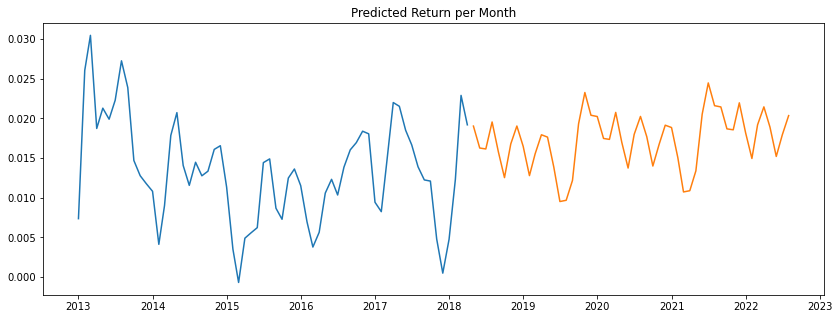

In [196]:
fig, ax = plt.subplots()

ax.plot(second['Percent'])
ax.plot(forecast2)
ax.set_title('Predicted Return per Month')

In [197]:
forecast2df = pd.DataFrame(forecast2)

In [198]:
for value in forecast2df['predicted_mean']: 
    forecast2df['Predicted Value'] = second['Value'][-1] + forecast2df['predicted_mean'] * second['Value'][-1]

In [199]:
forecast2df.head()

,predicted_mean,Predicted Value
2018-05-01,0.019035,227244.911540
2018-06-01,0.016268,226627.779959
2018-07-01,0.016149,226601.198818
2018-08-01,0.019554,227360.589494
2018-09-01,0.015771,226516.940397


#### Zipcode 94601

In [200]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_94601,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:4.0
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10.0


In [201]:
sari_mod3 =SARIMAX(train_94601,order=(0,1,0),
                  seasonal_order=(0,1,0,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

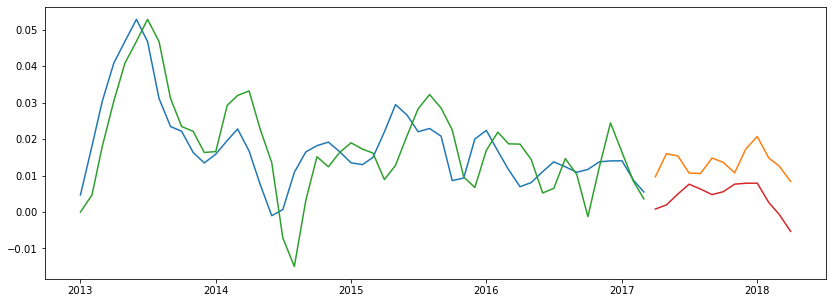

In [202]:
y_hat_train3 = sari_mod3.predict(typ='levels')
y_hat_test_sar3 = sari_mod3.predict(start=test_94601.index[0], end=test_94601.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train_94601)
ax.plot(test_94601)
ax.plot(y_hat_train3)
ax.plot(y_hat_test_sar3)

In [203]:
np.sqrt(mean_squared_error(test_94601, y_hat_test_sar3))

0.010192304739723003

In [204]:
sari_mod3 =SARIMAX(third['Percent'],order=(0,1,0),seasonal_order=(0,1,1,24),enforce_stationarity=
                   False,enforce_invertibility=False).fit()

In [205]:
forecast3 = sari_mod3.forecast(steps = 52)

Text(0.5, 1.0, 'Predicted Return per Month')

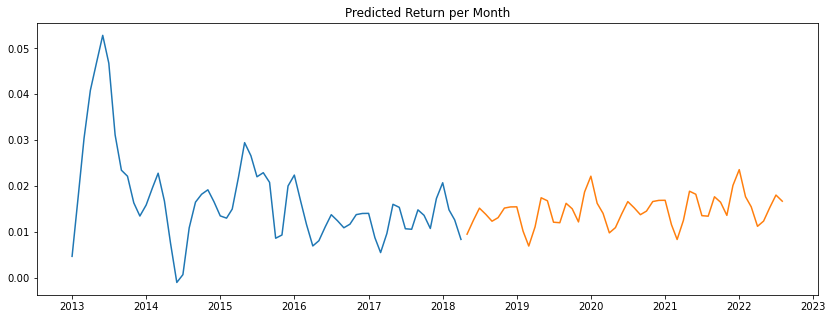

In [206]:
fig, ax = plt.subplots()

ax.plot(third['Percent'])
ax.plot(forecast3)
ax.set_title('Predicted Return per Month')

In [207]:
forecast3df = pd.DataFrame(forecast3)

In [208]:
for value in forecast3df['predicted_mean']: 
    forecast3df['Predicted Value'] = third['Value'][-1] + forecast3df['predicted_mean'] * third['Value'][-1]

In [209]:
forecast3df.head()

,predicted_mean,Predicted Value
2018-05-01,0.009502,572085.060350
2018-06-01,0.012501,573784.044295
2018-07-01,0.015176,575300.088837
2018-08-01,0.013840,574543.261992
2018-09-01,0.012326,573685.078086


#### Zipcode 30032

In [210]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_30032,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:4.0
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10.0


In [211]:
sari_mod4 =SARIMAX(train_30032,order=(0,1,0),
                  seasonal_order=(0,1,0,16),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

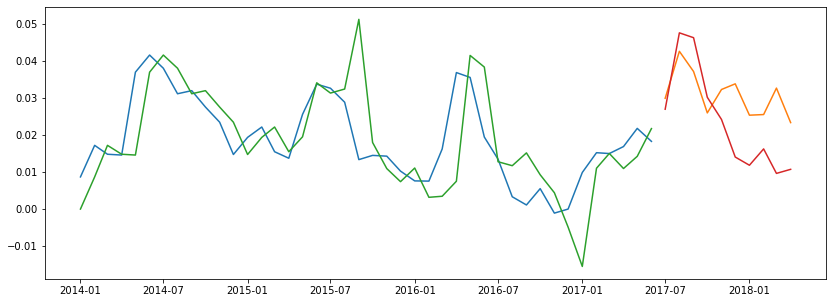

In [212]:
y_hat_train4 = sari_mod4.predict(typ='levels')
y_hat_test_sar4 = sari_mod4.predict(start=test_30032.index[0], end=test_30032.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train_30032)
ax.plot(test_30032)
ax.plot(y_hat_train4)
ax.plot(y_hat_test_sar4)

In [213]:
np.sqrt(mean_squared_error(test_30032, y_hat_test_sar4))

0.012446343198612056

In [214]:
sari_mod4 =SARIMAX(fourth['Percent'],order=(0,1,0),seasonal_order=(0,1,1,24),enforce_stationarity=
                   False,enforce_invertibility=False).fit()

In [215]:
forecast4 = sari_mod4.forecast(steps = 52)

Text(0.5, 1.0, 'Predicted Return per Month')

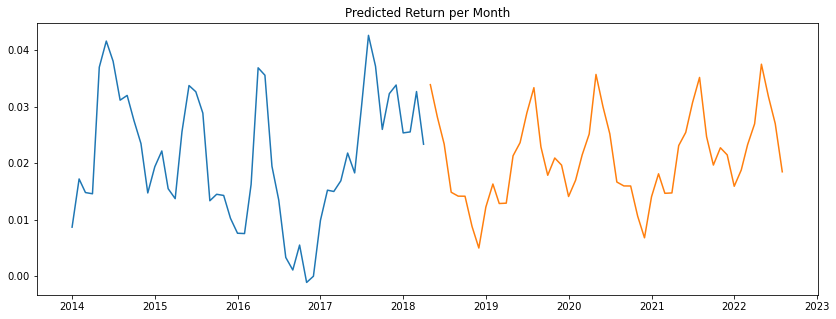

In [216]:
fig, ax = plt.subplots()

ax.plot(fourth['Percent'])
ax.plot(forecast4)
ax.set_title('Predicted Return per Month')

In [217]:
forecast4df = pd.DataFrame(forecast4)

In [218]:
for value in forecast4df['predicted_mean']: 
    forecast4df['Predicted Value'] = fourth['Value'][-1] + forecast4df['predicted_mean'] * fourth['Value'][-1]

In [219]:
forecast4df.head()

,predicted_mean,Predicted Value
2018-05-01,0.033877,140503.912177
2018-06-01,0.028142,139724.454712
2018-07-01,0.023370,139075.929711
2018-08-01,0.014853,137918.534872
2018-09-01,0.014162,137824.597928


#### Zipcode 94804

In [220]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =SARIMAX(train_94804,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            print('hello')
            continue

ARIMA(0, 1, 0)x(0, 1, 0, 52) - AIC:2.0
ARIMA(0, 1, 0)x(0, 1, 1, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(0, 1, 0, 52) - AIC:4.0
ARIMA(0, 1, 1)x(0, 1, 1, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 0, 52) - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:4.0
ARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:6.0
ARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 0, 52) - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 52) - AIC:10.0


In [221]:
sari_mod5 =SARIMAX(train_94804,order=(0,1,0),
                  seasonal_order=(0,1,0,10),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

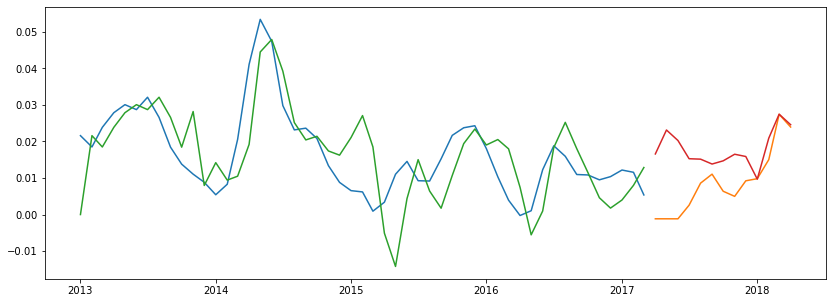

In [222]:
y_hat_train5 = sari_mod5.predict(typ='levels')
y_hat_test_sar5 = sari_mod5.predict(start=test_94804.index[0], end=test_94804.index[-1],typ='levels')

fig, ax = plt.subplots()
ax.plot(train_94804)
ax.plot(test_94804)
ax.plot(y_hat_train5)
ax.plot(y_hat_test_sar5)

In [223]:
np.sqrt(mean_squared_error(test_94804, y_hat_test_sar5))

0.011957743141227842

In [224]:
sari_mod5 =SARIMAX(fifth['Percent'],order=(0,1,0),seasonal_order=(0,1,1,24),enforce_stationarity=
                   False,enforce_invertibility=False).fit()

In [225]:
forecast5 = sari_mod5.forecast(steps = 52)

Text(0.5, 1.0, 'Predicted Return per Month')

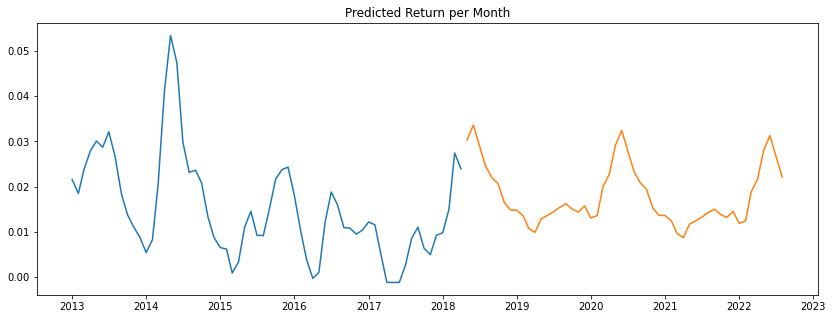

In [226]:
fig, ax = plt.subplots()

ax.plot(fifth['Percent'])
ax.plot(forecast5)
ax.set_title('Predicted Return per Month')

In [227]:
forecast5df = pd.DataFrame(forecast5)

In [228]:
for value in forecast5df['predicted_mean']: 
    forecast5df['Predicted Value'] = fifth['Value'][-1] + forecast5df['predicted_mean'] * fifth['Value'][-1]

In [232]:
forecast5df

,predicted_mean,Predicted Value
2018-05-01,0.030318,497746.649014
2018-06-01,0.033613,499338.345312
2018-07-01,0.029068,497142.960441
2018-08-01,0.024453,494913.446033
2018-09-01,0.021980,493718.516806
2018-10-01,0.020618,493060.413778
2018-11-01,0.016478,491060.469771
2018-12-01,0.014846,490271.988500
2019-01-01,0.014782,490241.289655
2019-02-01,0.013582,489661.656563


### Observations and Analysis

Zipcode 85035

In [254]:
first['Value'][0]

62000

In [265]:
print('2019-05-01', (160870.870649 - first['Value'][0])/first['Value'][0])
print('2020-05-01', (160081.989421 - first['Value'][0])/first['Value'][0])
print('2021-05-01', (159293.108193 - first['Value'][0])/first['Value'][0])

2019-05-01 1.594691462080645
2020-05-01 1.5819675713064516
2021-05-01 1.569243680532258


Zipcode 85008

In [255]:
second['Value'][0]

95900

In [266]:
print('2019-05-01', (226934.740737 - second['Value'][0])/second['Value'][0])
print('2020-01-01', (227514.430300 - second['Value'][0])/second['Value'][0])
print('2021-05-01', (225985.399370 - second['Value'][0])/second['Value'][0])

2019-05-01 1.3663685165484878
2020-01-01 1.3724132460896767
2021-05-01 1.3564692322210636


In [271]:
bestRetZip['RegionName'].unique()

array([85008, 94601, 94804, 85035, 30032])

Zipcode 94601

In [256]:
third['Value'][0]

193700

In [267]:
print('2019-05-01', (576584.358804 - third['Value'][0])/third['Value'][0])
print('2020-05-01', (572893.427983 - third['Value'][0])/third['Value'][0])
print('2021-05-01', (577392.726437 - third['Value'][0])/third['Value'][0])

2019-05-01 1.9766874486525552
2020-05-01 1.9576325657356735
2021-05-01 1.9808607456737222


Zipcode 30032

In [257]:
fourth['Value'][0]

46500

In [262]:
print('2019-12-01', (138570.707768 - fourth['Value'][0])/fourth['Value'][0])
print('2020-05-01', (140749.594424 -  fourth['Value'][0])/fourth['Value'][0])
print('2021-05-01', (139040.116609 - fourth['Value'][0])/fourth['Value'][0])

2019-12-01 -0.26759668198731507
2020-05-01 -0.2560803677378435
2021-05-01 -0.26511566274312903


Zipcode 94804

In [258]:
fifth['Value'][0]

189200

In [261]:
print('2019-05-01', (489333.421802 - fifth['Value'][0])/fifth['Value'][0])
print('2020-05-01', (497178.443764 - fifth['Value'][0])/fifth['Value'][0])
print('2021-05-01', (488765.216551 - fifth['Value'][0])/fifth['Value'][0])

2019-05-01 1.5863288678752645
2020-05-01 1.6277930431501058
2021-05-01 1.5833256688742072
